# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/11rep_25noiseLevel_MM_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/12rep_25noiseLevel_MM_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/13rep_25noiseLevel_MM_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/11rep_25noiseLevel_MM_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/12rep_25noiseLevel_MM_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/13rep_25noiseLevel_MM_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.313121        0.198570  0.049394  0.280100  0.019996   
       0.25   0.301542        0.198097  0.050457  0.291291  0.032105   
       0.50   0.321522        0.198695  0.049415  0.269185  0.060252   
       0.75   0.314205        0.196844  0.046861  0.223302  0.085243   
       1.00   0.315805        0.191687  0.045264  0.192072  0.107006   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.198402  0.009866  0.040315  0.050526  0.000000  
       0.25  0.192209  0.007224  0.041619  0.053100  0.000300  
       0.50  0.195369  0.006220  0.038058  0.058212  0.001064  
       0.75  0.196236  0.006716  0.037579  0.062617  0.002302  
       1.00  0.195815  0.007632  0.033268  0.070194  0.003626

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.303547        0.196593  0.050303  0.287244  0.020377   
       0.25   0.303766        0.202850  0.050961  0.278534  0.034302   
       0.50   0.316876        0.200940  0.049312  0.262566  0.057606   
       0.75   0.311647        0.199072  0.047332  0.223280  0.084514   
       1.00   0.313147        0.197257  0.046978  0.193159  0.103345   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.192326  0.010001  0.039880  0.048991  0.000000  
       0.25  0.197139  0.007273  0.039128  0.051773  0.000314  
       0.50  0.184220  0.005851  0.036951  0.055229  0.001062  
       0.75  0.196282  0.006500  0.035658  0.065194  0.002192  
       1.00  0.198211  0.007569  0.035029  0.067514  0.003787

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.294657        0.203769  0.049944  0.303389  0.020673   
       0.25   0.302292        0.194158  0.050300  0.285513  0.033946   
       0.50   0.305250        0.206205  0.049690  0.252106  0.059102   
       0.75   0.319695        0.208697  0.046349  0.222889  0.085516   
       1.00   0.315169        0.203409  0.045094  0.189859  0.109044   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.202662  0.010338  0.040861  0.051848  0.000000  
       0.25  0.199312  0.007116  0.042196  0.053946  0.000305  
       0.50  0.196170  0.005857  0.038411  0.060518  0.001036  
       0.75  0.198443  0.006733  0.034933  0.063892  0.002235  
       1.00  0.200744  0.007405  0.033168  0.072854  0.003803

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.303775        0.199644  0.049881  0.290244  0.020348   
         0.25   0.296572        0.199046  0.054568  0.262964  0.054008   
         0.50   0.297008        0.202129  0.062116  0.197535  0.111619   
         0.75   0.284511        0.200001  0.069373  0.127909  0.155451   
         1.00   0.270430        0.193444  0.079186  0.079888  0.175059   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.197797  0.010068  0.040352  0.050455  0.000000  
         0.25  0.191052  0.011460  0.041096  0.053910  0.000133  
         0.50  0.178723  0.014108  0.037771  0.064359  0.000477  
         0.75  0.176869  0.017358  0.035466  0.079384  0.001080  
         1.00  0.170674  0.020551  0.033007  0.096571  0.001929

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  6.021797e+01  3.965937e+01      36.880618  5.574897e+01   
         0.25  4.597010e+06  2.294929e+06  214219.910302  1.441146e+06   
         0.50  5.451159e+06  3.497433e+06  341183.971996  2.236004e+06   
         0.75  5.726004e+06  4.126494e+06  408818.111883  2.730130e+06   
         1.00  6.057275e+06  4.578212e+06  465078.810171  3.116428e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      27.062855  5.388111e+01  5.585060e+01      18.852295   
         0.25  469978.007769  2.319278e+06  2.580479e+06  435504.919384   
         0.50  738128.337554  3.792402e+06  3.246965e+06  629849.063469   
         0.75  889270.280685  4.747093e+06  3.533031e+06  766039.737492   
         1.00  975484.234929  5.500615e+06  3.769851e+06  849383.737291   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.617375  
         0.25     188009.306526  
         0.50     280431.577574  
         0.75     354339.814474  
         1.00     406697.817528

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


,,Missing Values,% of Total Values


,,Missing Values,% of Total Values


# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


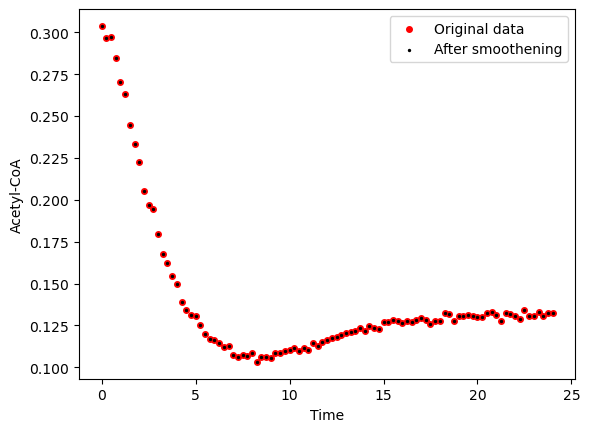

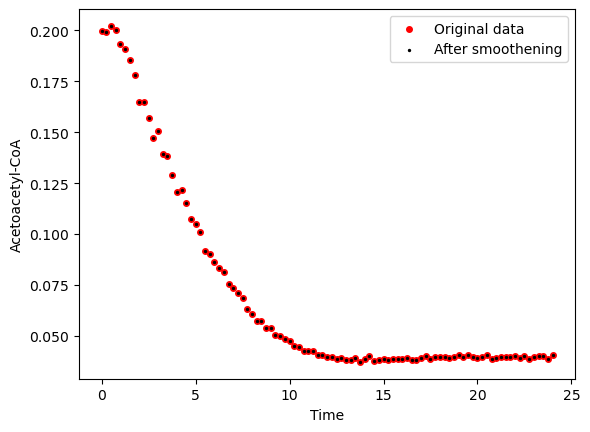

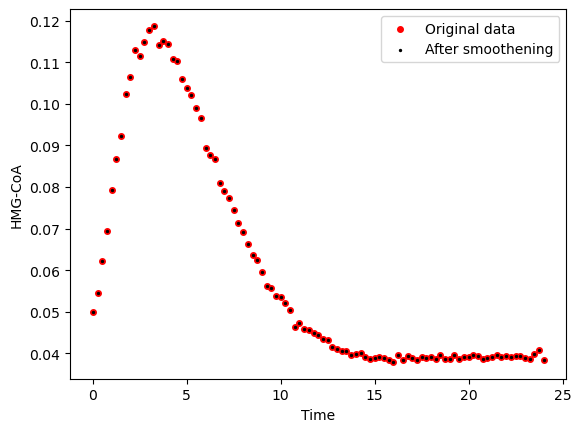

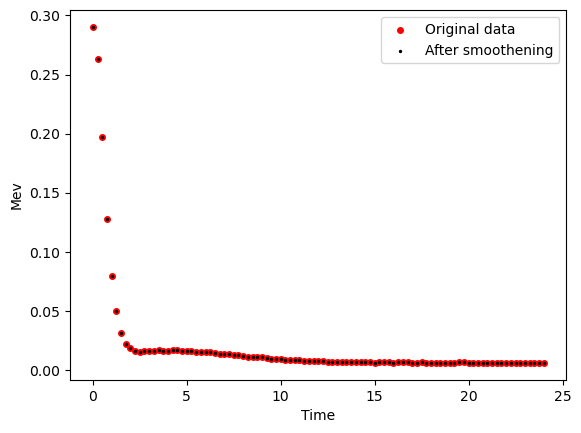

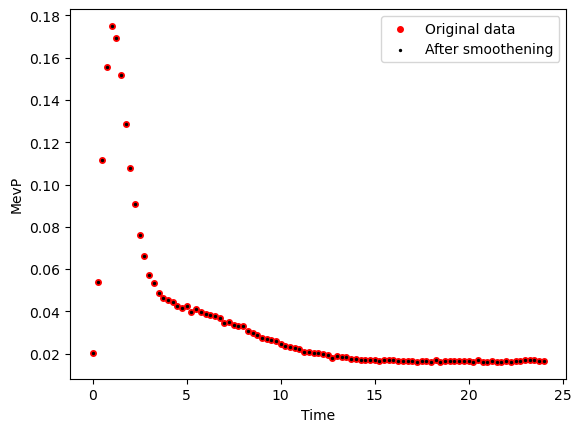

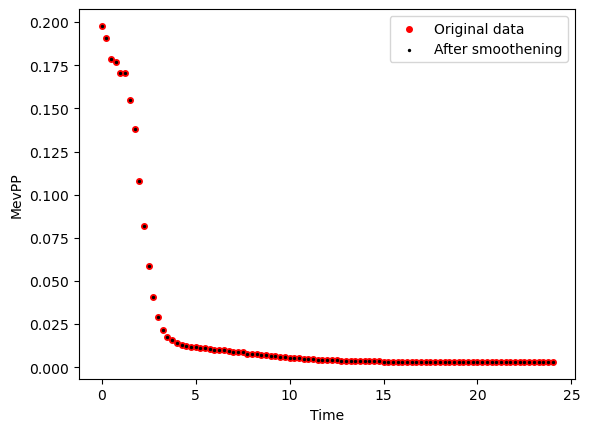

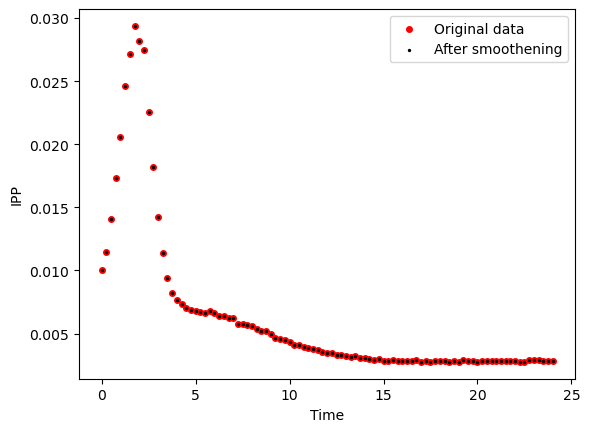

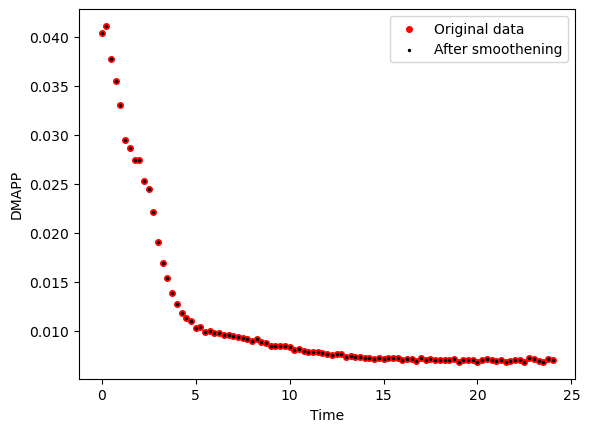

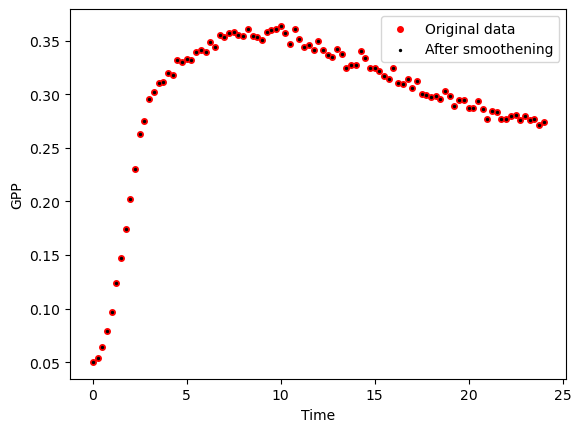

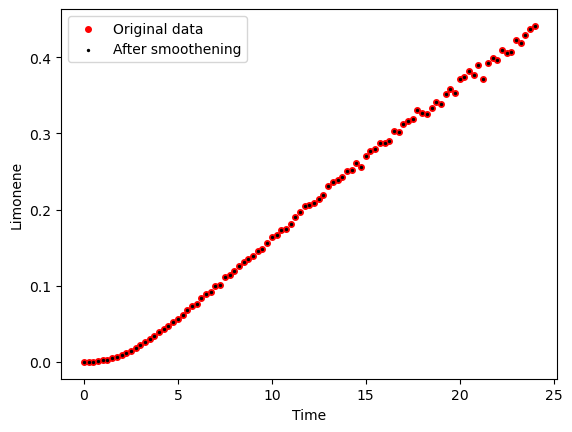

Strain Strain 2


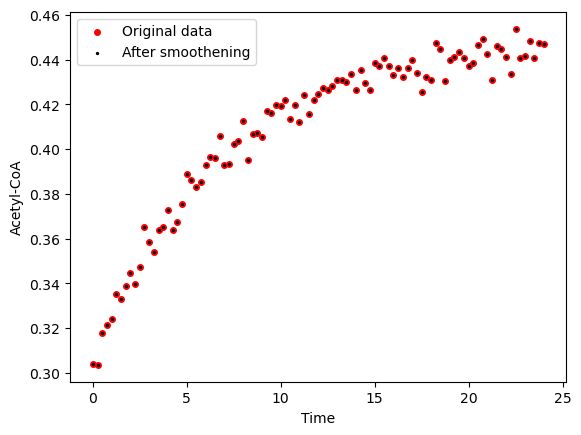

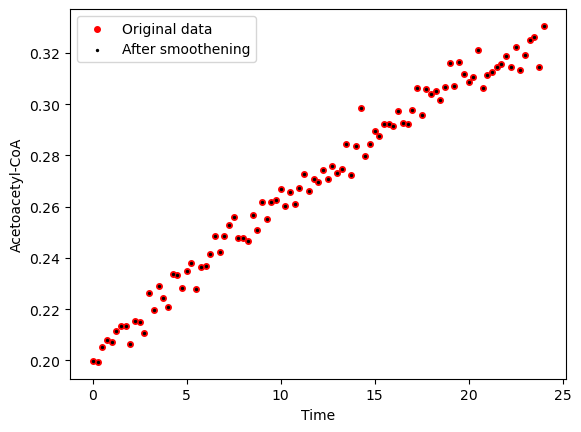

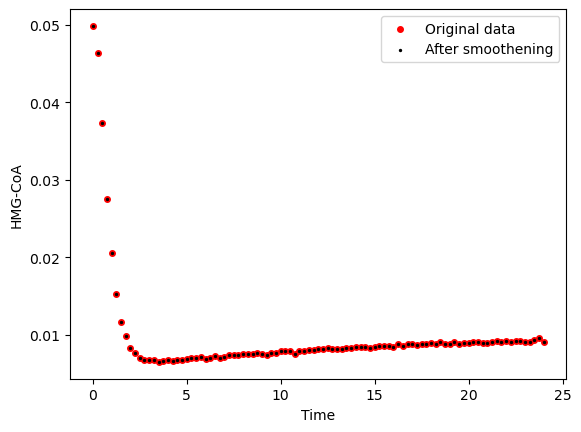

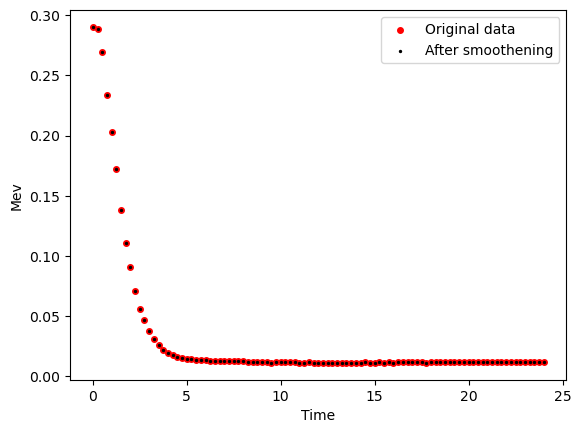

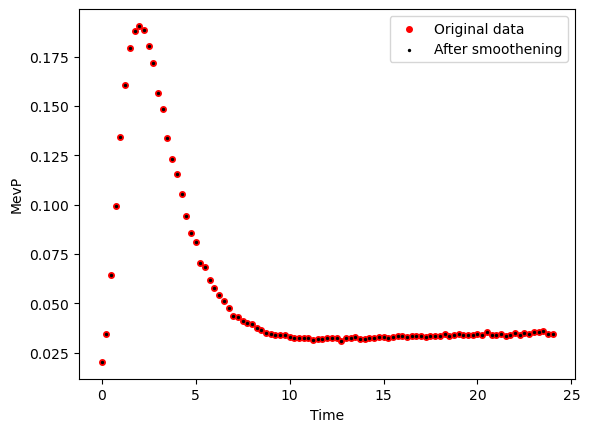

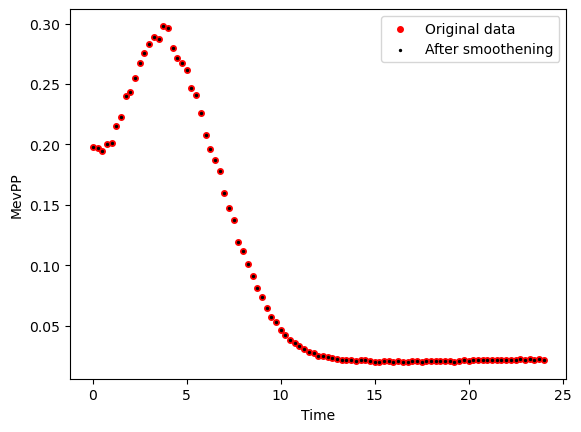

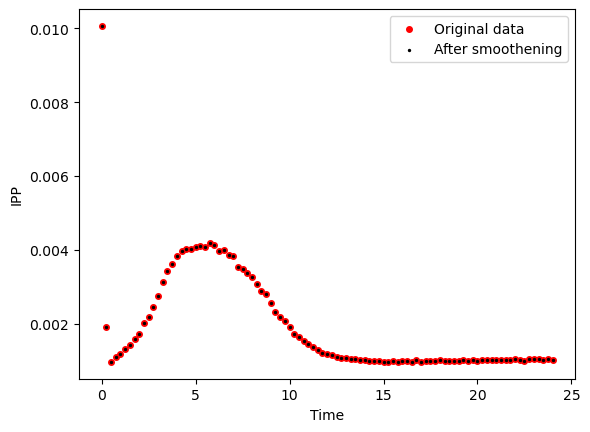

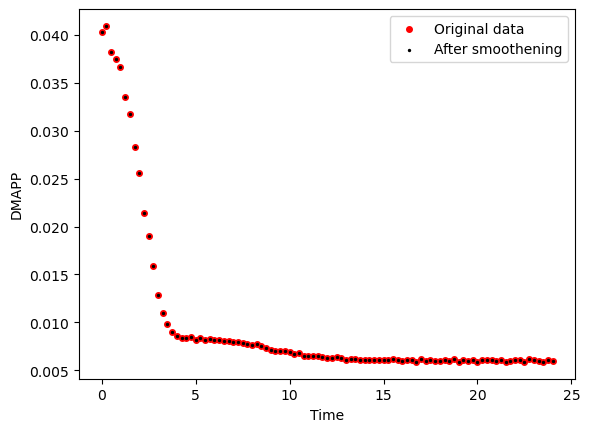

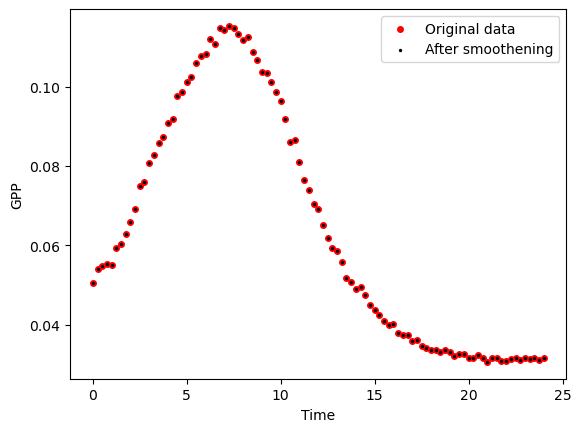

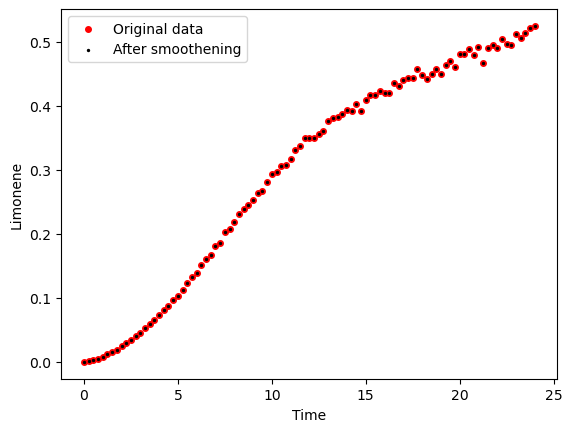

Strain Strain 3


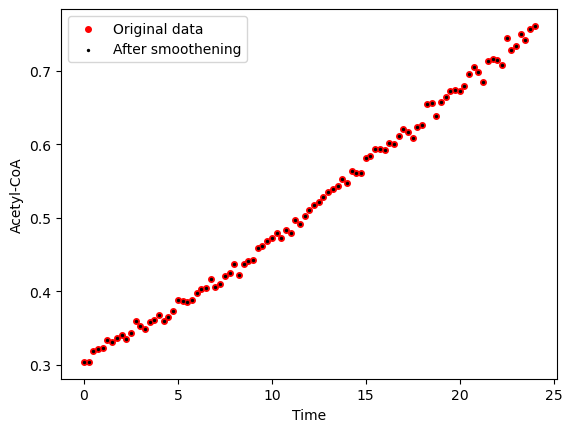

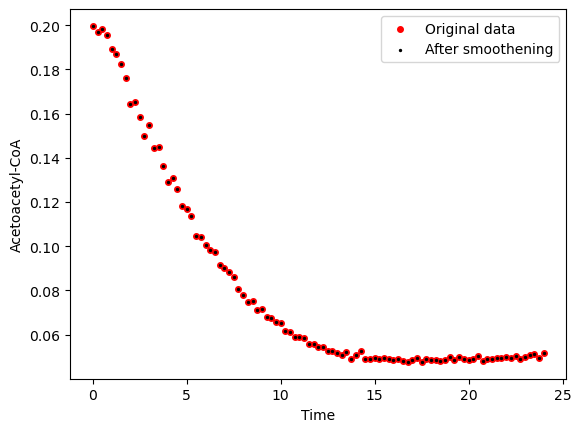

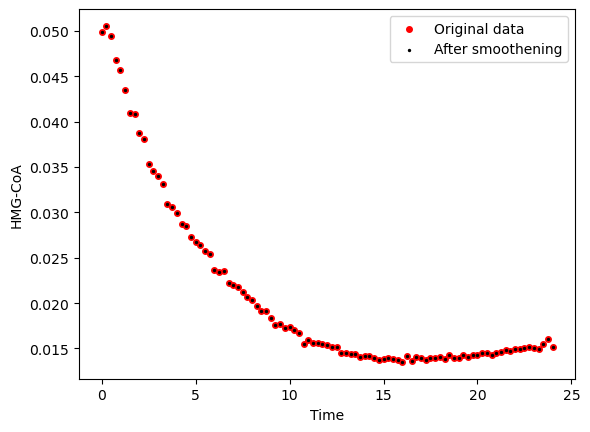

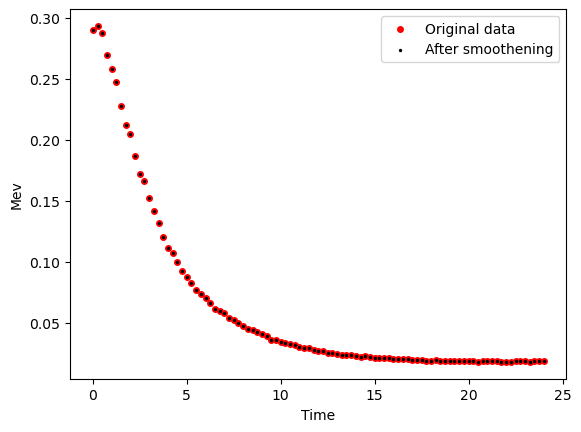

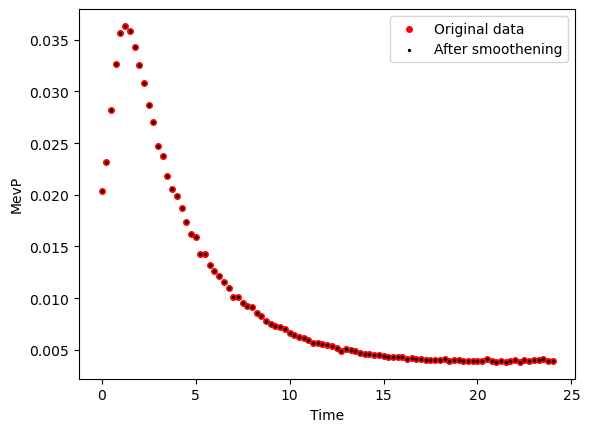

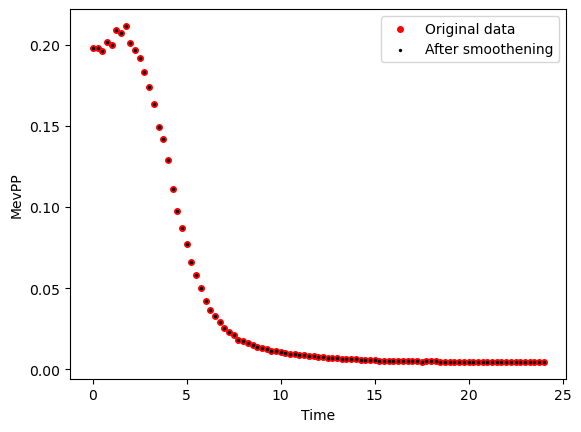

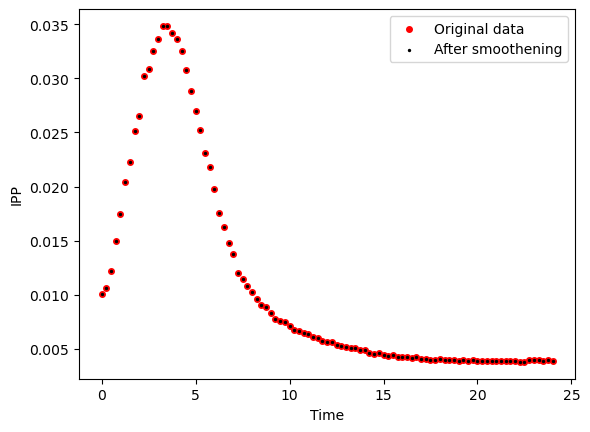

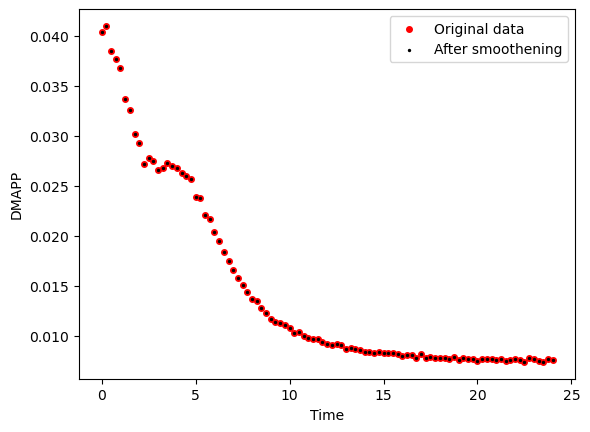

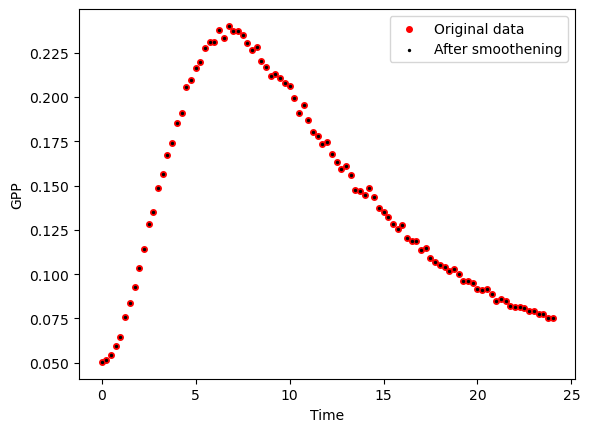

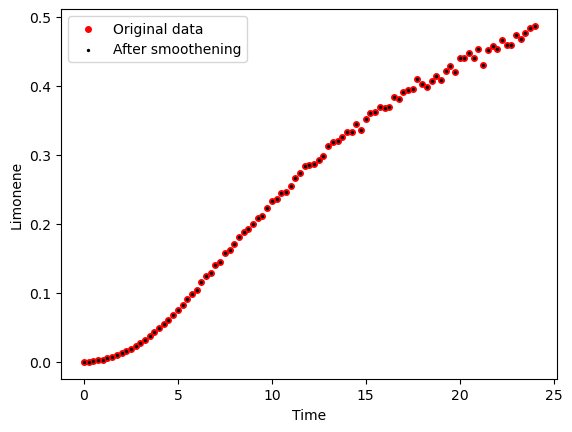

Strain WT


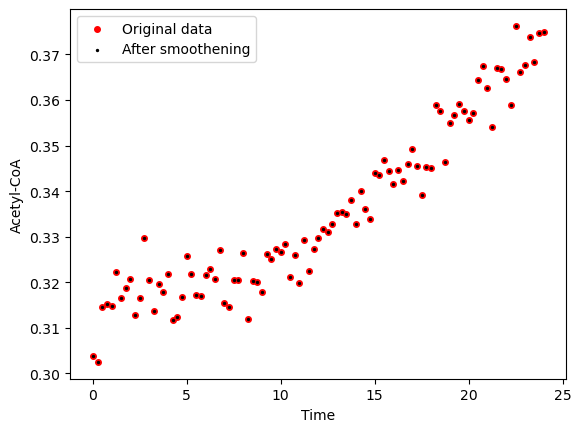

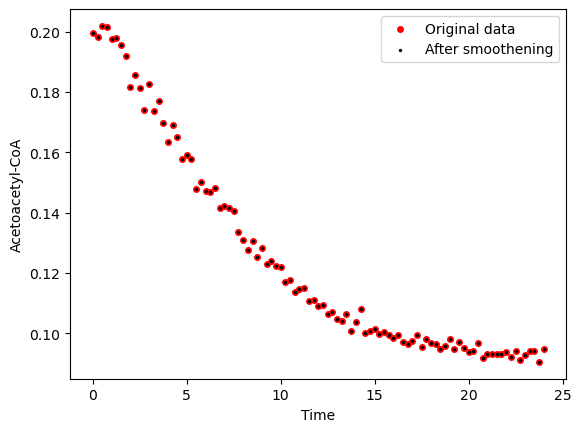

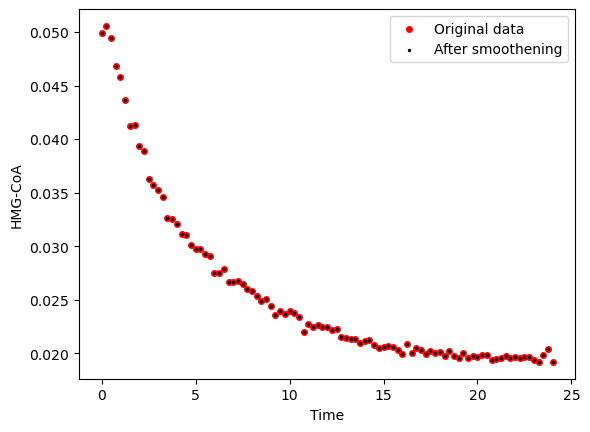

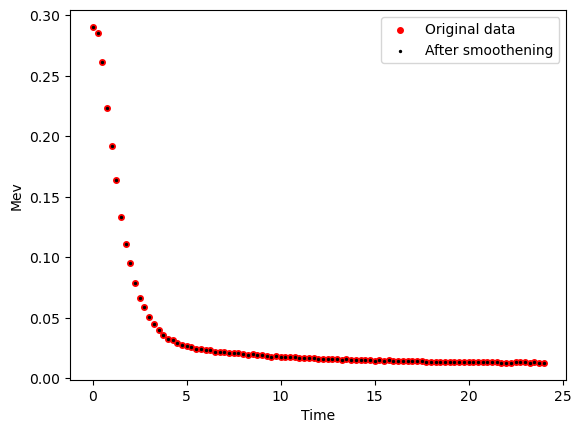

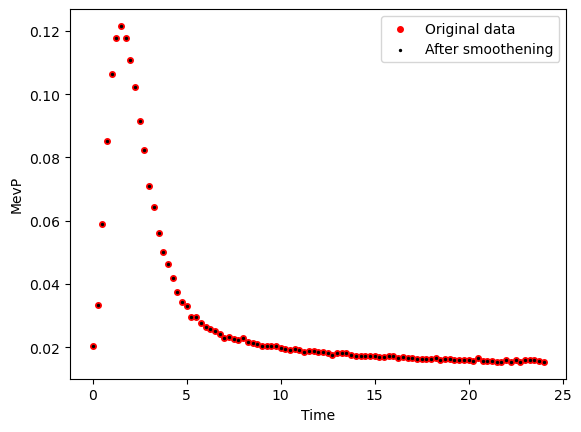

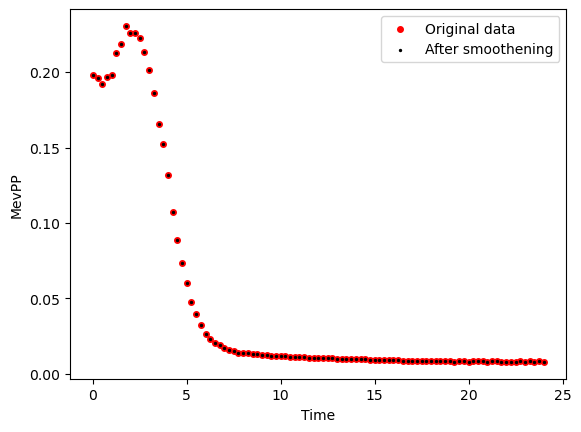

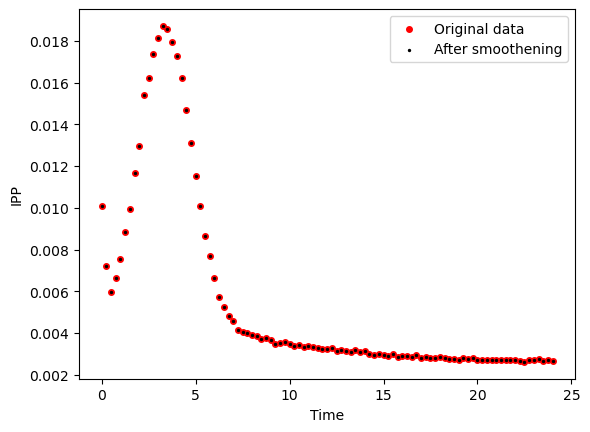

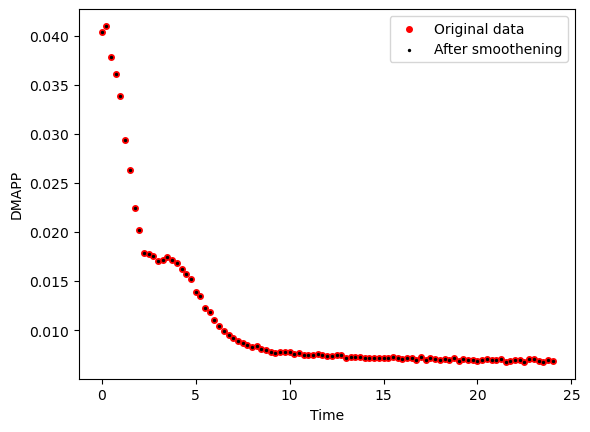

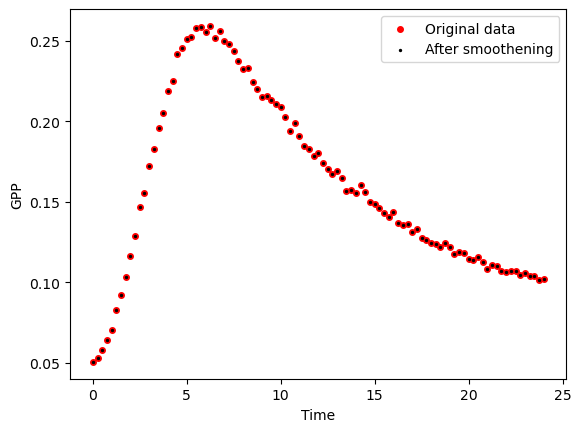

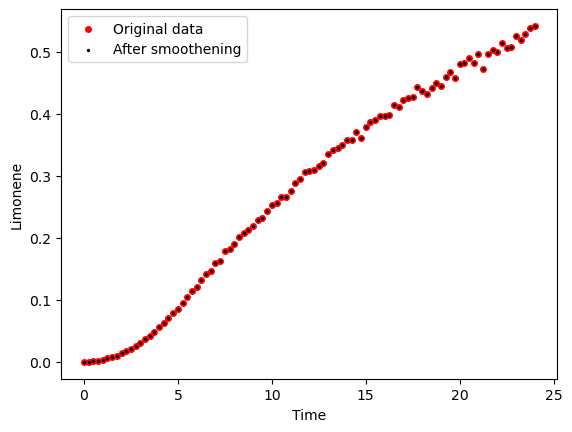

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


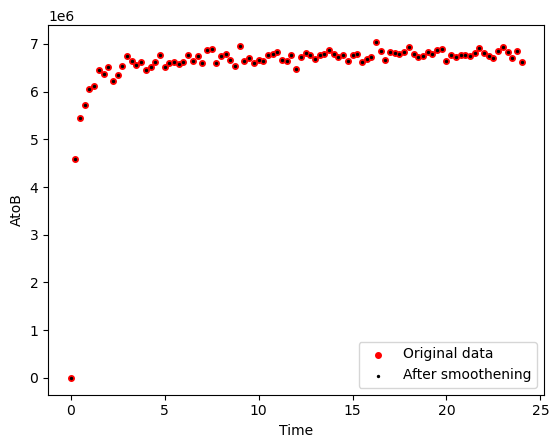

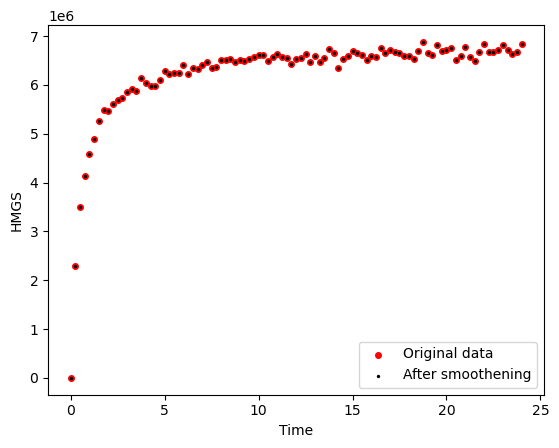

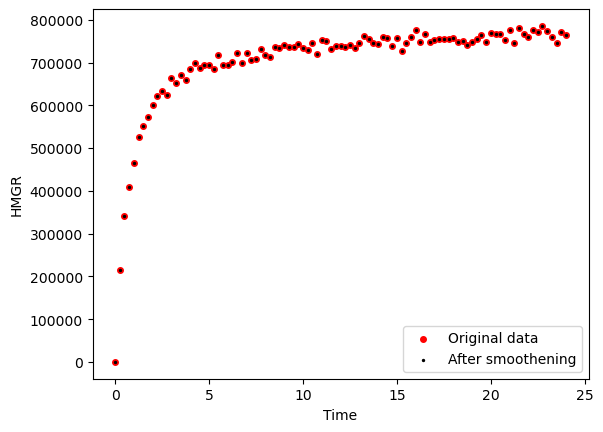

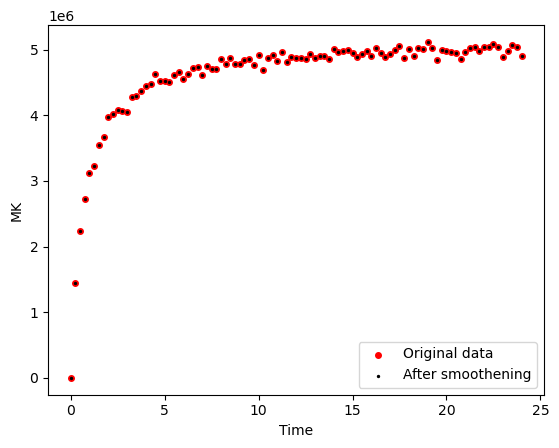

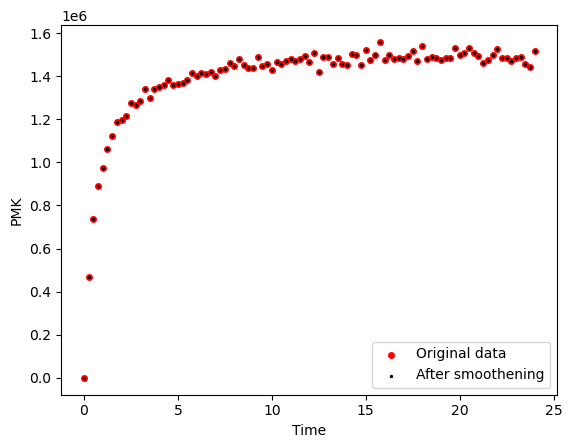

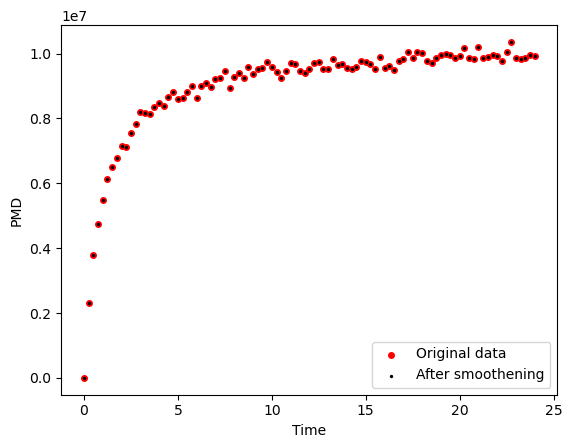

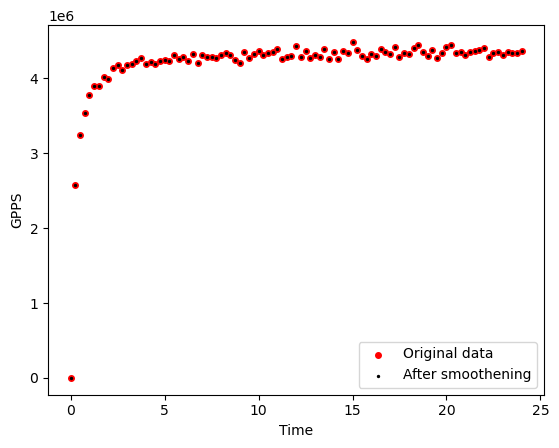

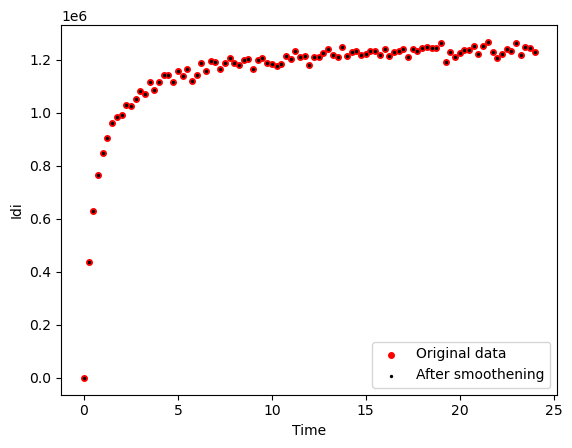

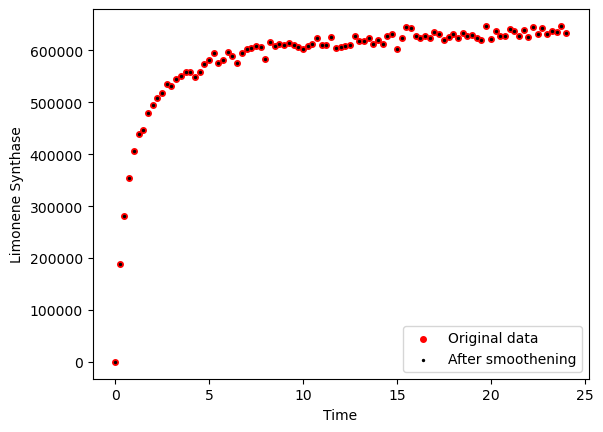

Strain Strain 2


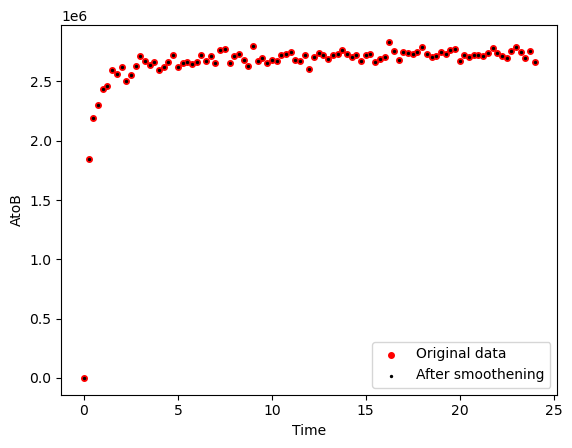

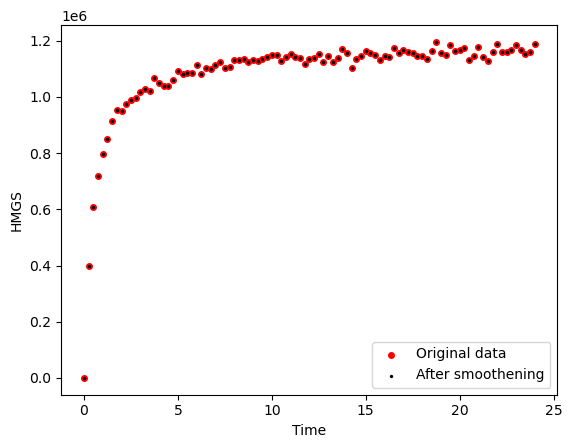

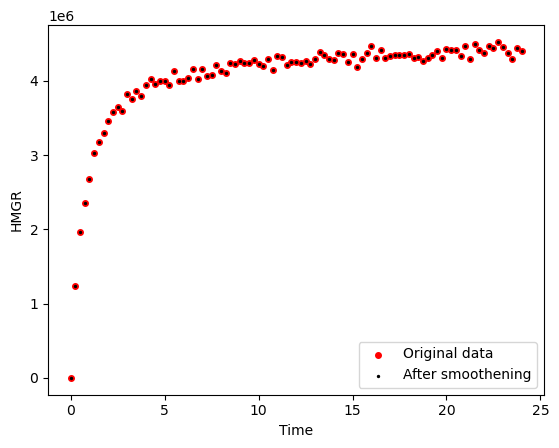

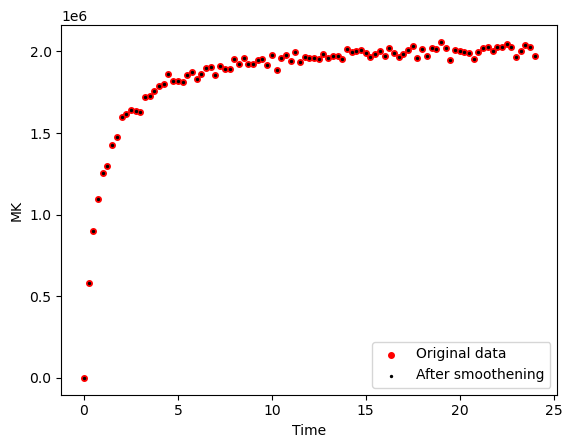

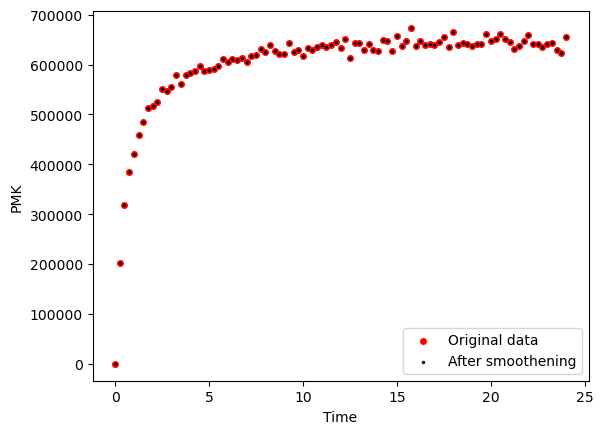

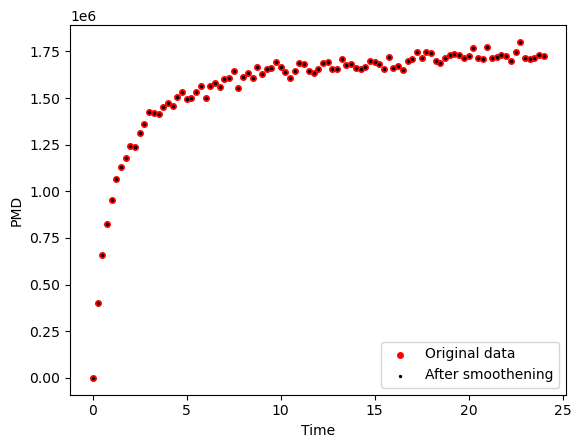

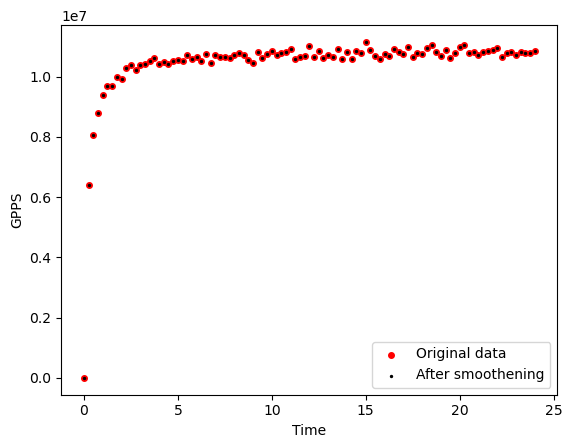

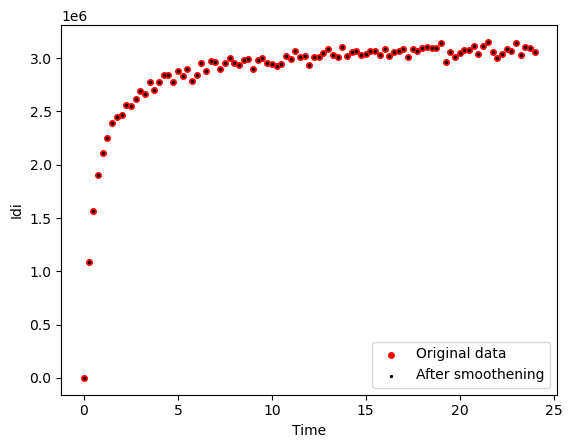

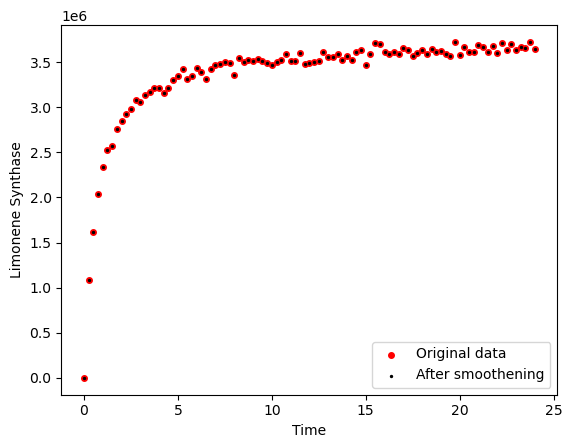

Strain Strain 3


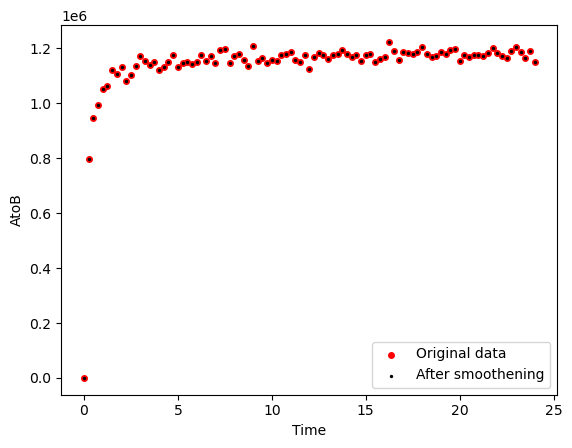

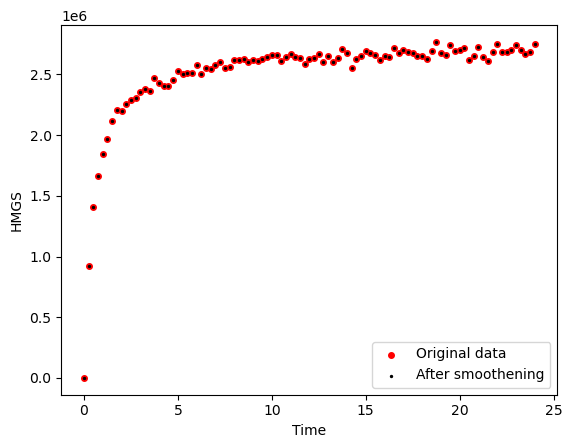

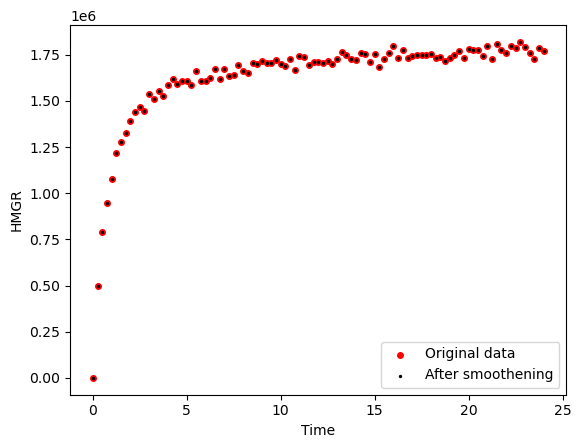

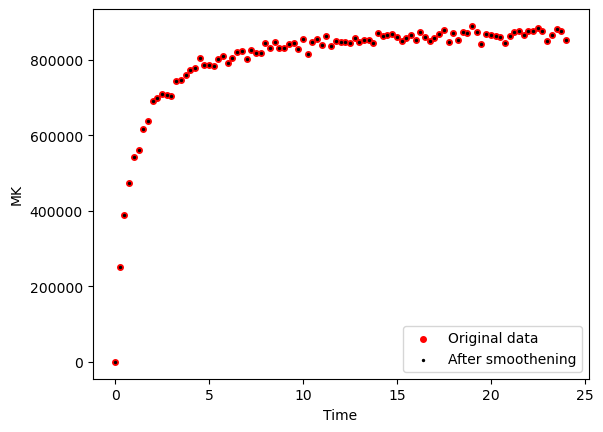

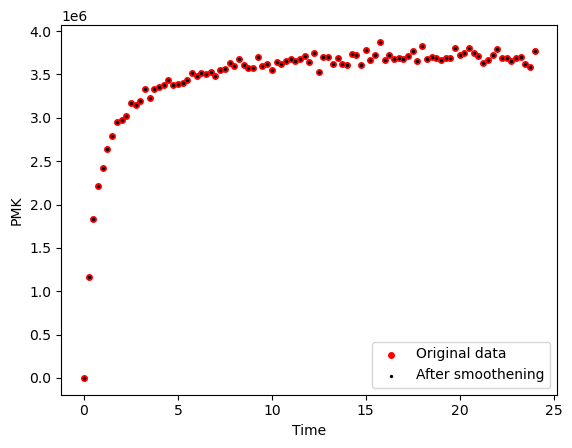

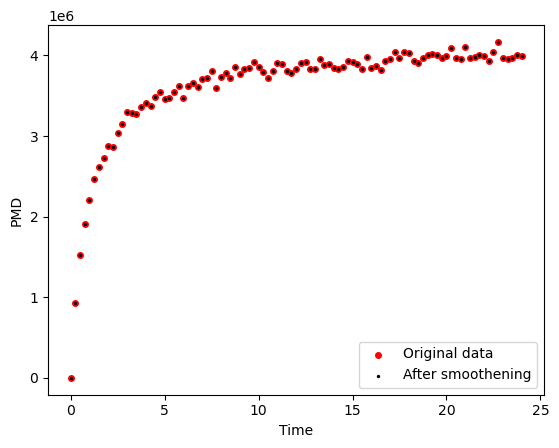

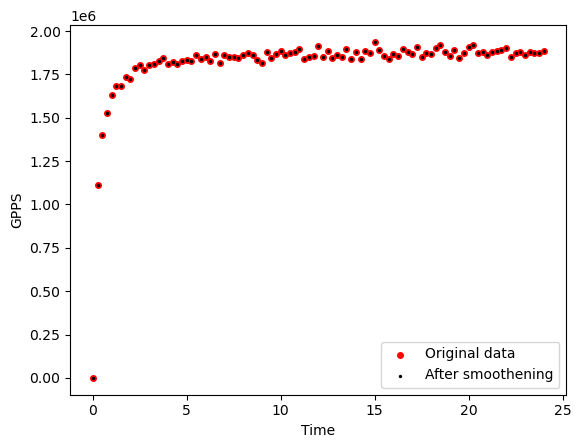

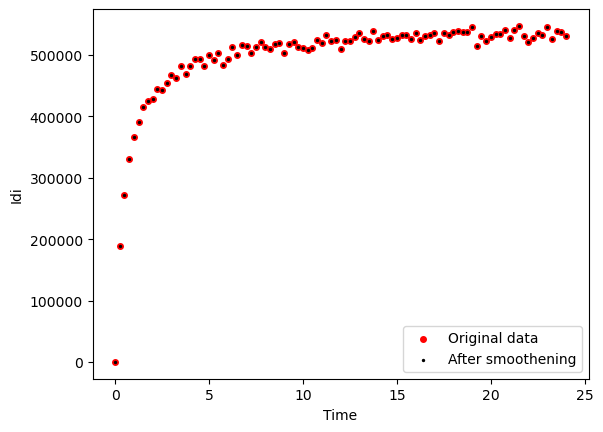

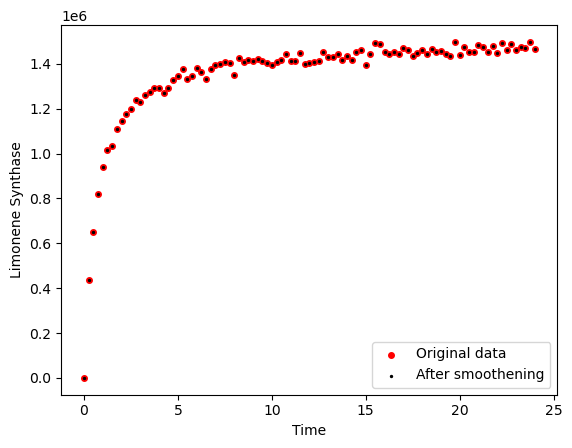

Strain WT


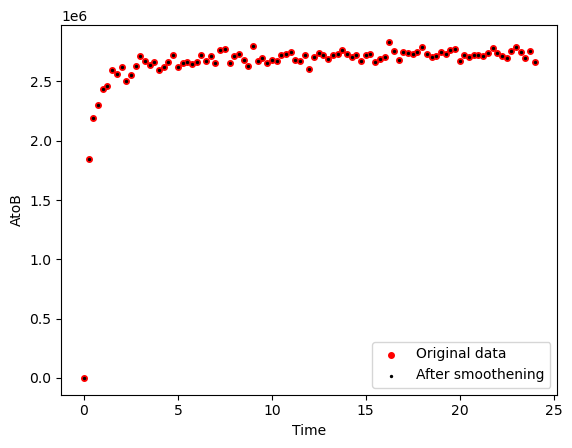

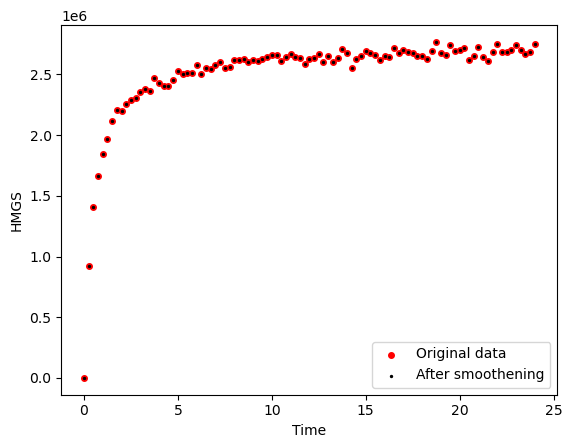

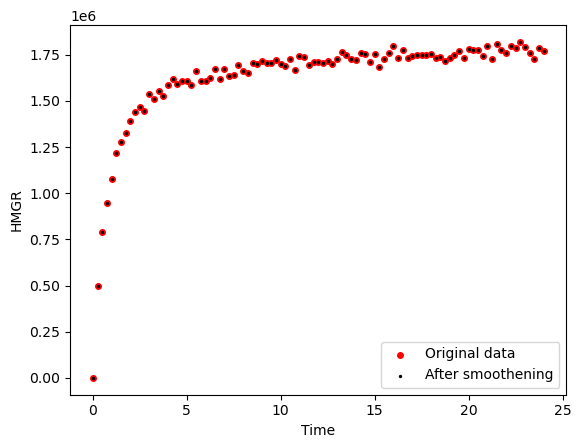

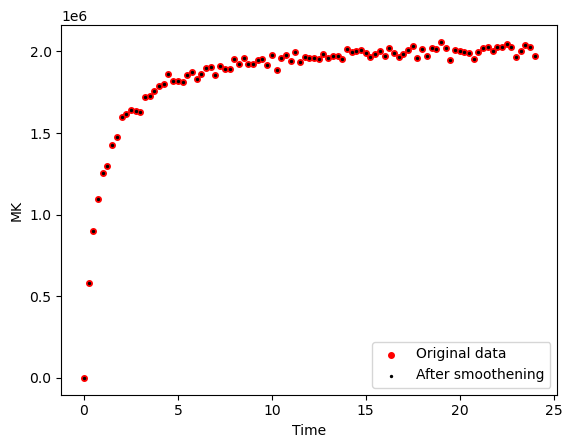

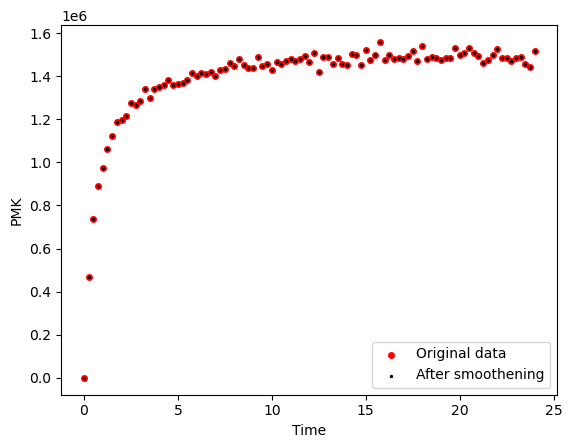

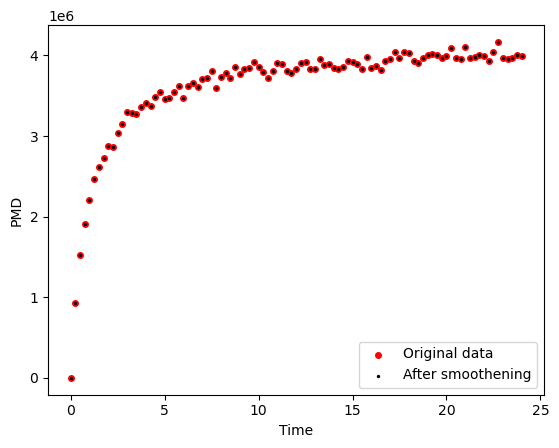

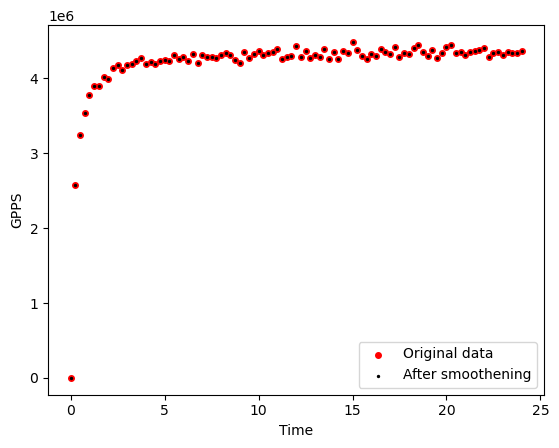

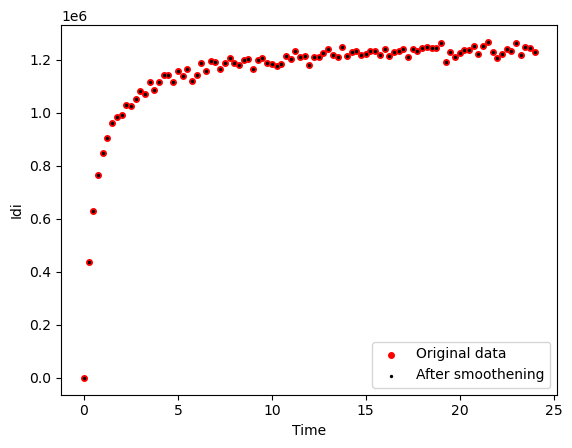

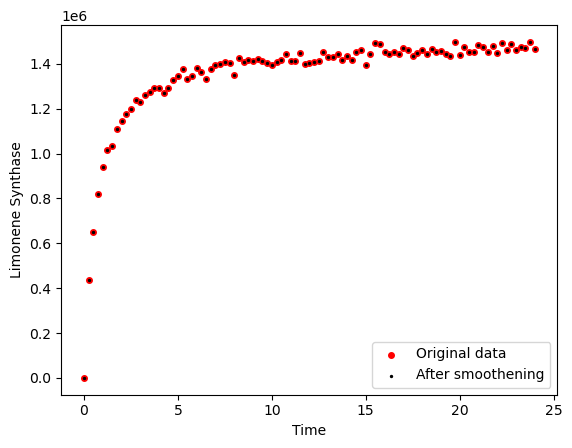

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative52

df_allSmooth=estimate_state_derivative52(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.303775        0.199644  0.049881  0.290244  0.020348   
         0.25    0.296572        0.199046  0.054568  0.262964  0.054008   
         0.50    0.297008        0.202129  0.062116  0.197535  0.111619   
         0.75    0.284511        0.200001  0.069373  0.127909  0.155451   
         1.00    0.270430        0.193444  0.079186  0.079888  0.175059   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.367778        0.092700  0.019379  0.013157  0.016010   
         23.25   0.373861        0.094028  0.019195  0.012698  0.015992   
         23.50   0.368283        0.094140  0.019805  0.013077  0.016069   
         23.75   0.374691        0.090554  0.020364  0.013029  0.015511   
         24.00   0.375006        0.094851  0.019183  0.013034  0.015433   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.197797  0.010068  0.040352  0.050455  0.000000  ...   
         0.25   0.191052  0.011460  0.041096  0.053910  0.000133  ...   
         0.50   0.178723  0.014108  0.037771  0.064359  0.000477  ...   
         0.75   0.176869  0.017358  0.035466  0.079384  0.001080  ...   
         1.00   0.170674  0.020551  0.033007  0.096571  0.001929  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.007967  0.002724  0.007029  0.105559  0.524676  ...   
         23.25  0.008291  0.002739  0.006835  0.103980  0.519342  ...   
         23.50  0.007966  0.002651  0.006779  0.103791  0.529465  ...   
         23.75  0.008240  0.002702  0.007004  0.101528  0.537875  ...   
         24.00  0.007936  0.002645  0.006917  0.101994  0.541683  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00    -0.000999        0.014998  0.017983 -0.170104  0.212211   
         0.25    -0.016250        0.005210  0.023675 -0.196206  0.188279   
         0.50    -0.031501       -0.004577  0.029366 -0.222308  0.164346   
         0.75    -0.037502       -0.010023  0.032545 -0.217703  0.117675   
         1.00    -0.050317       -0.017099  0.031136 -0.164298  0.037826   
...                    ...             ...       ...       ...       ...   
WT       23.00   -0.003260        0.001068 -0.000023 -0.000264  0.000397   
         23.25    0.007100        0.000029  0.000748 -0.000207  0.000061   
         23.50    0.006115        0.000331  0.000310  0.000035 -0.000654   
         23.75    0.006372        0.001610 -0.000857  0.000321 -0.001085   
         24.00    0.006630        0.002888 -0.002025  0.000607 -0.001516   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.040599  0.005938 -0.001972  0.010464 -0.000012  
         0.25  -0.033985  0.008342 -0.005050  0.028773  0.000955  
         0.50  -0.027371  0.010746 -0.008128  0.047082  0.001922  
         0.75  -0.019778  0.013118 -0.011251  0.069019  0.002945  
         1.00  -0.021489  0.013323 -0.009715  0.084180  0.004131  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.000107  0.000031 -0.000110 -0.002697  0.022900  
         23.25 -0.000064 -0.000046 -0.000193 -0.003153  0.026160  
         23.50 -0.000045 -0.000077 -0.000022 -0.003833  0.021018  
         23.75 -0.000421 -0.000080  0.000260 -0.002681  0.030487  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

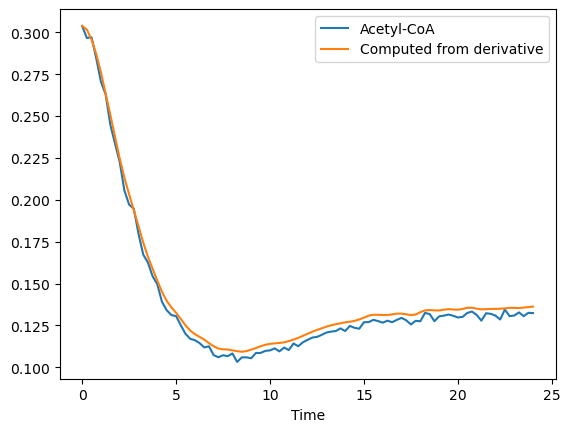

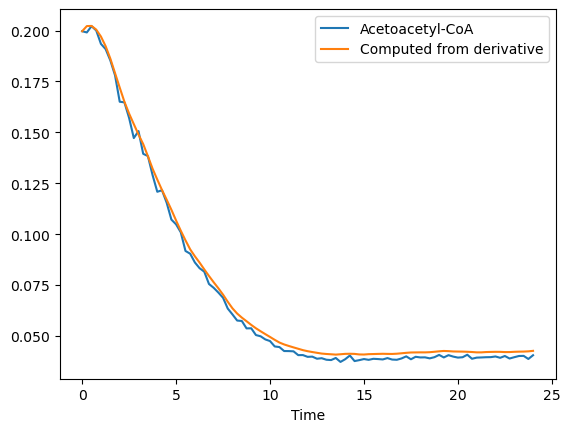

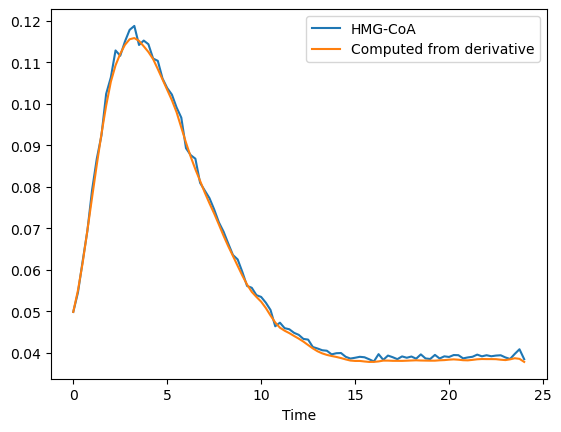

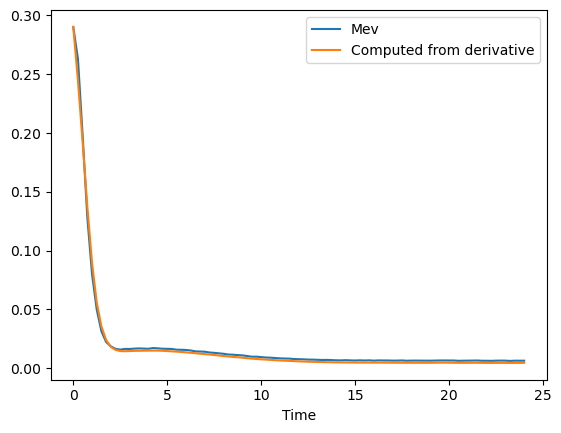

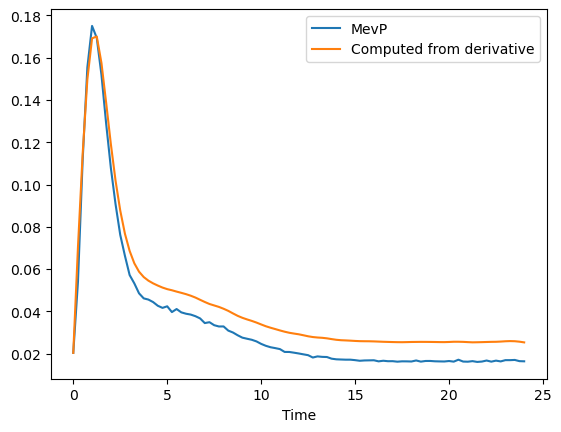

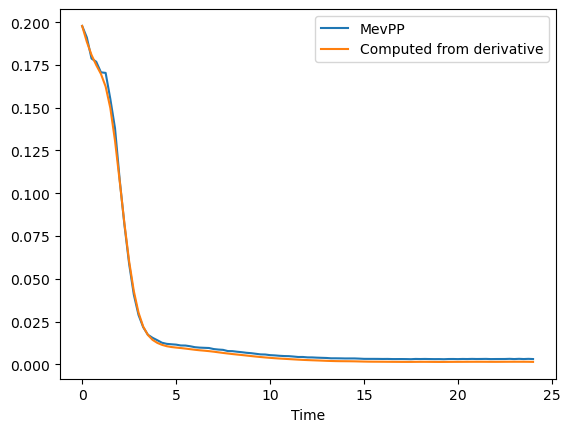

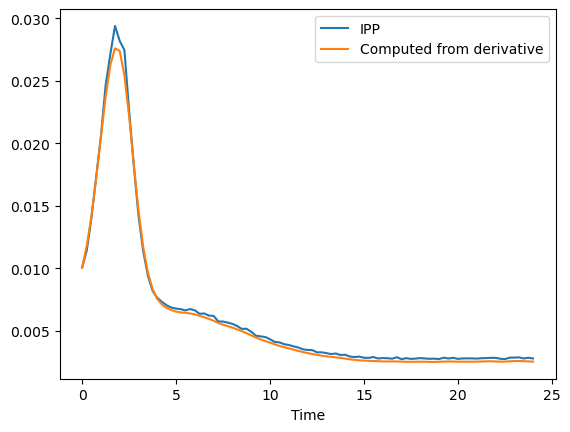

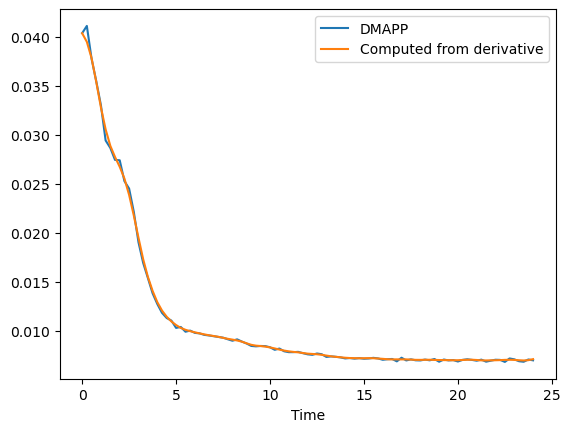

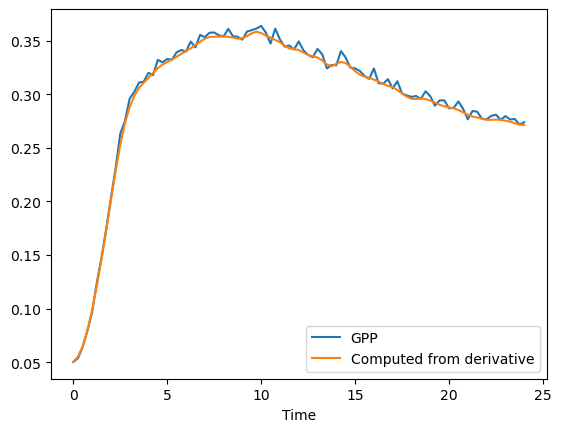

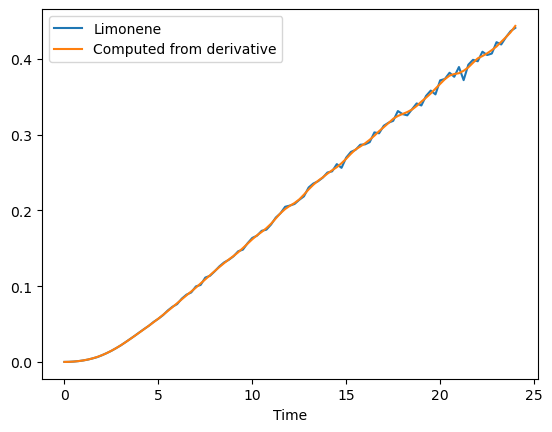

'Time profile from derivative vs. actual profile for Strain 2'

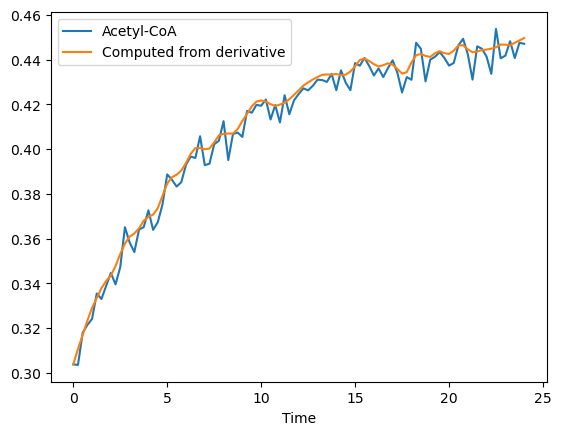

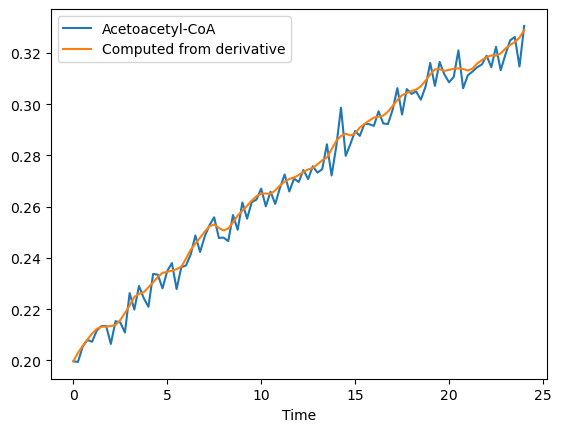

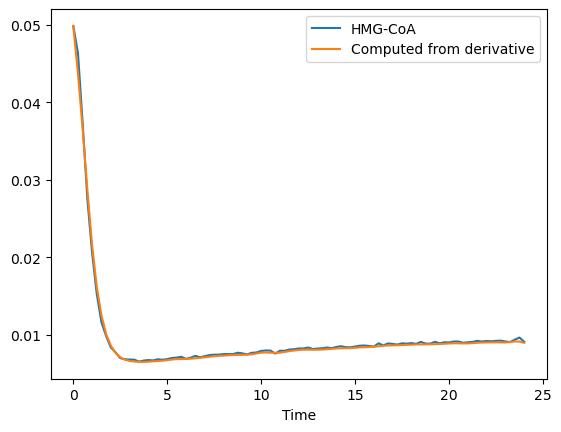

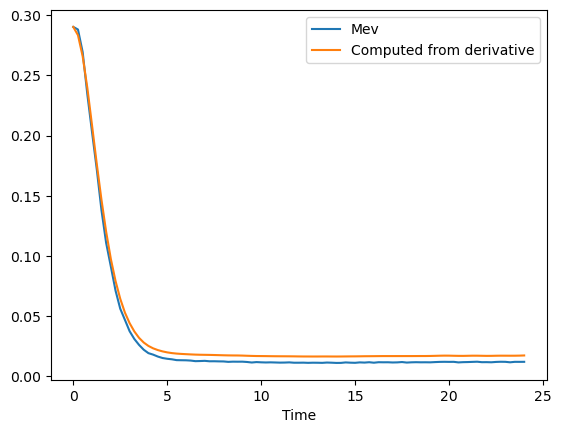

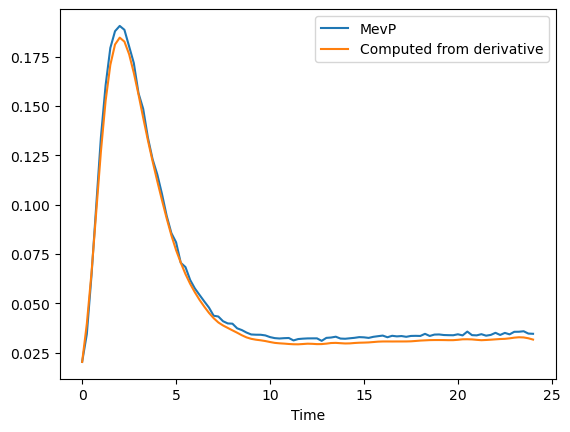

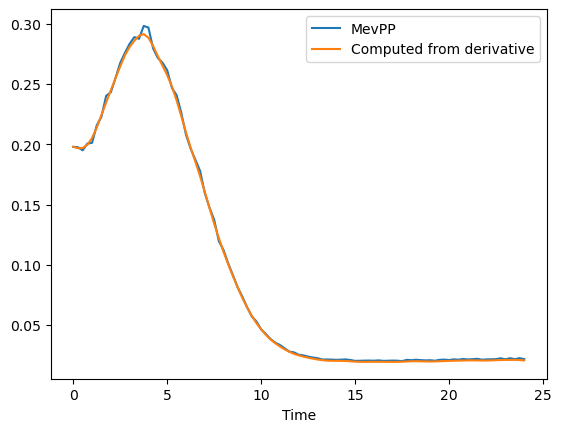

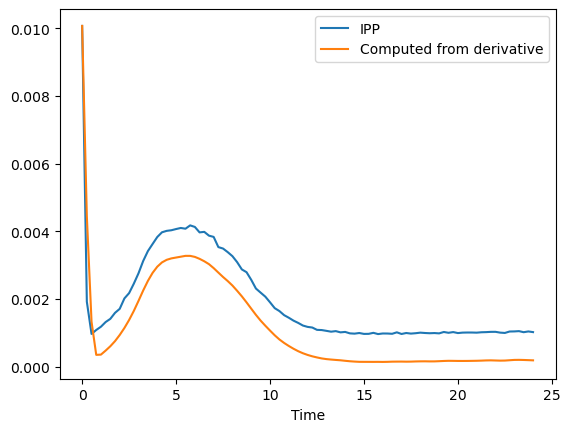

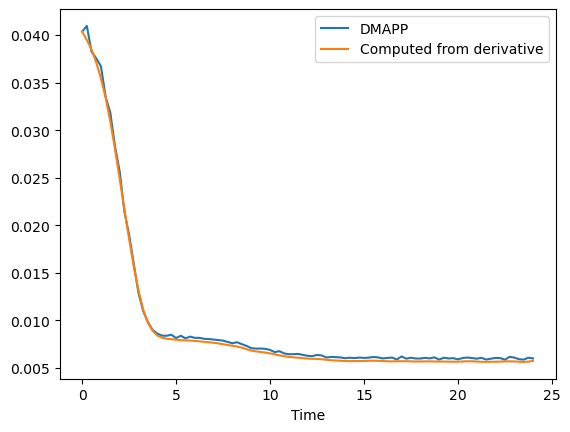

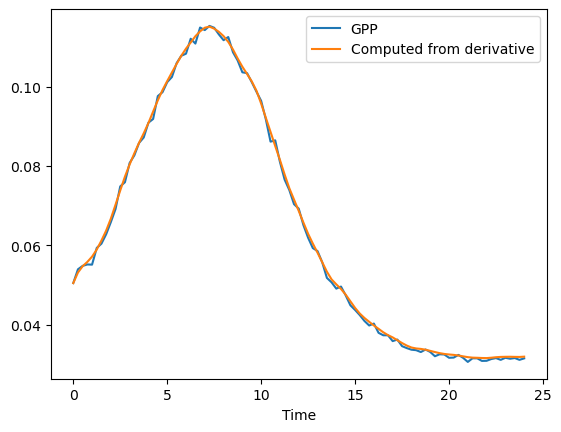

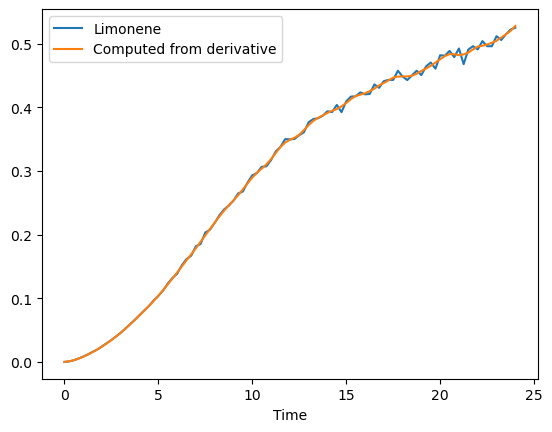

'Time profile from derivative vs. actual profile for Strain 3'

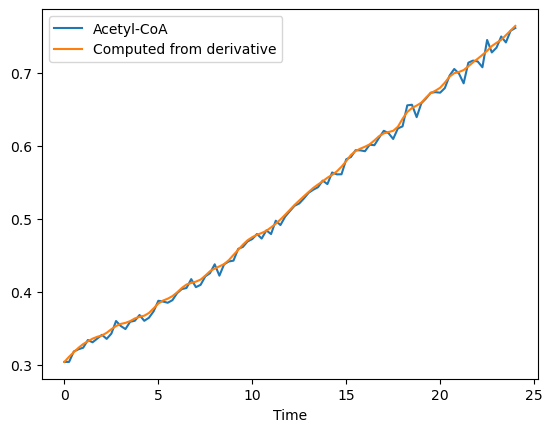

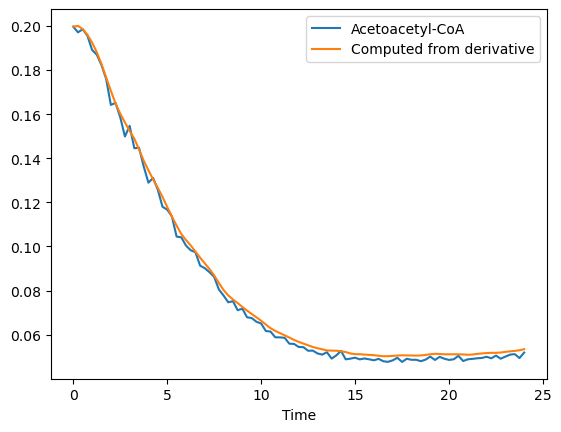

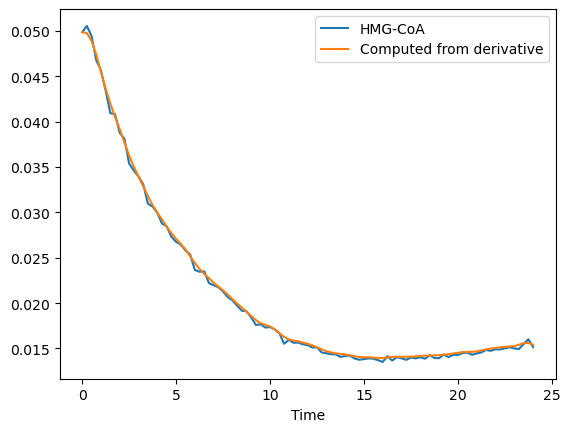

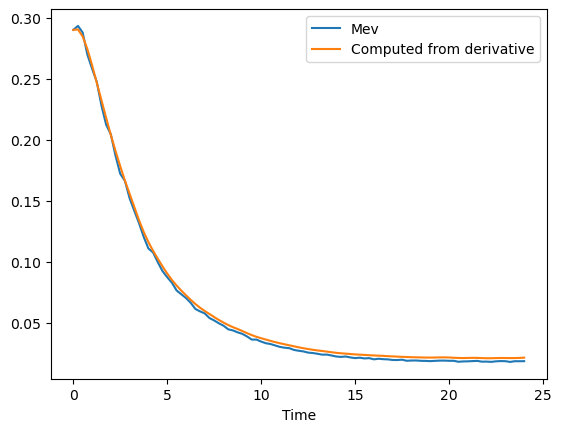

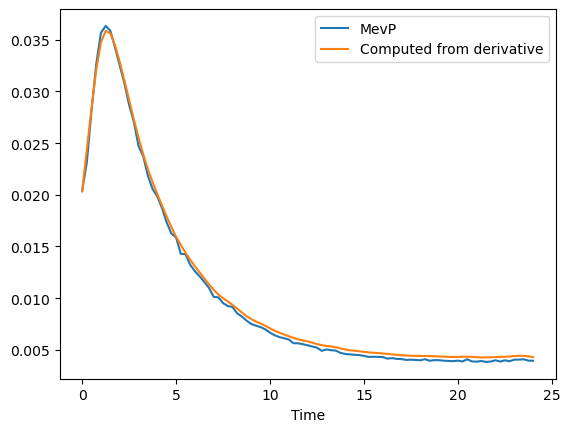

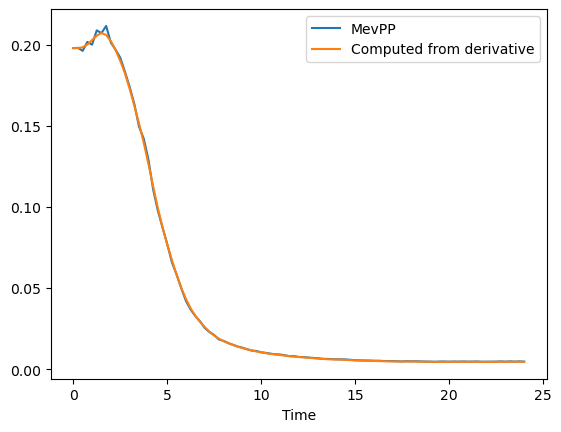

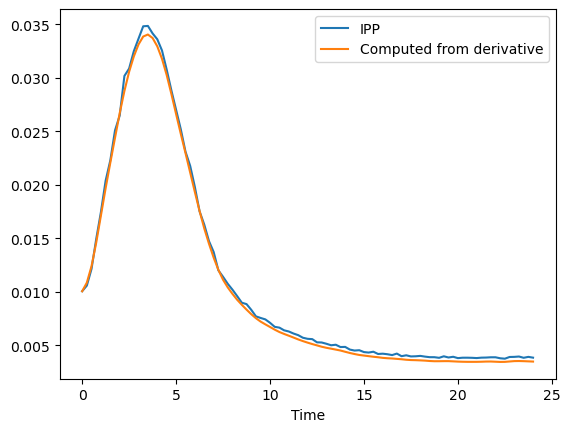

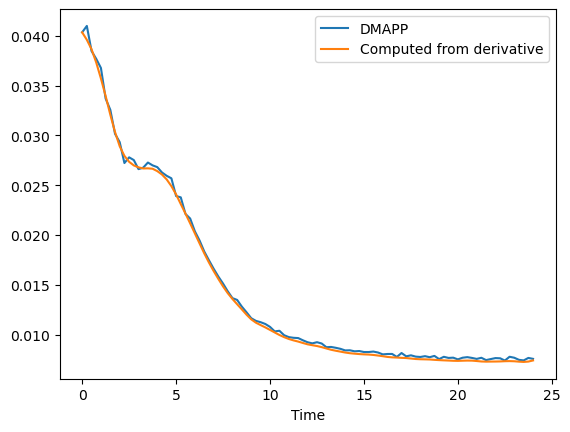

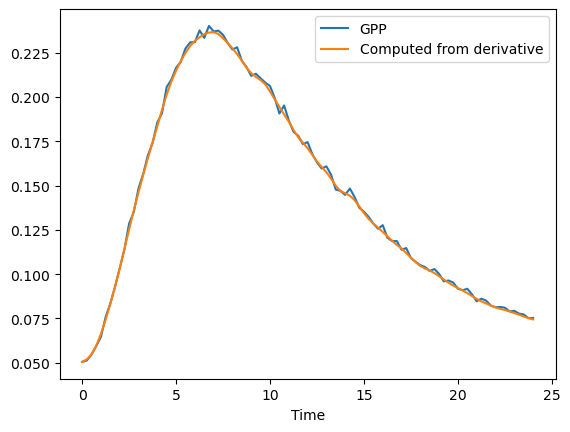

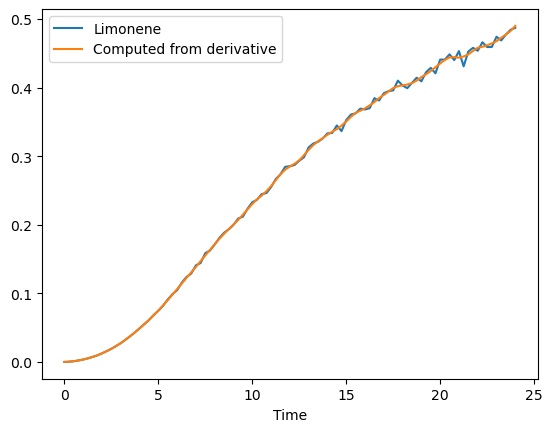

'Time profile from derivative vs. actual profile for WT'

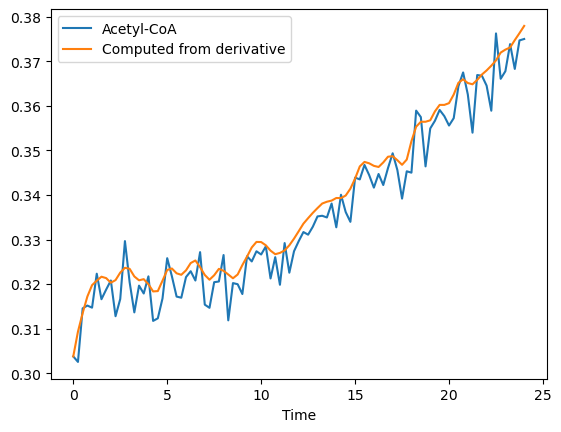

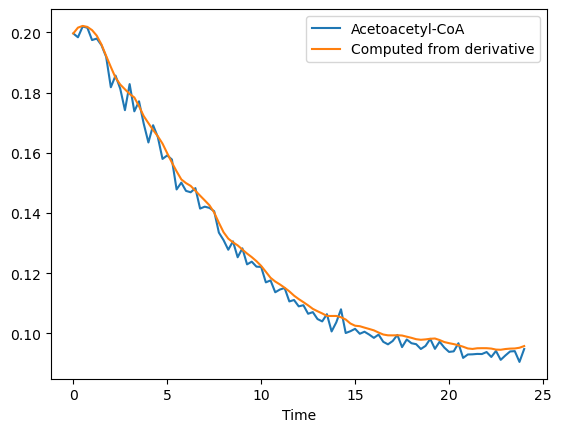

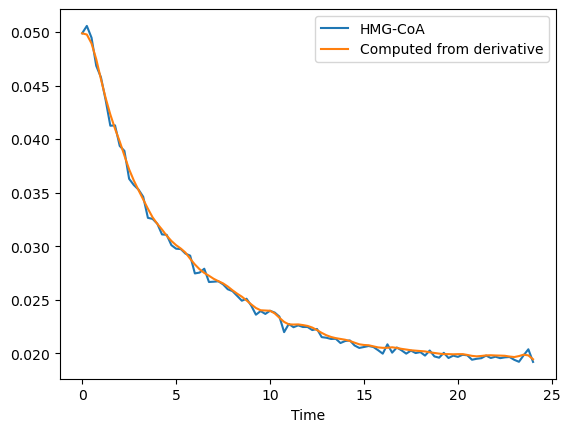

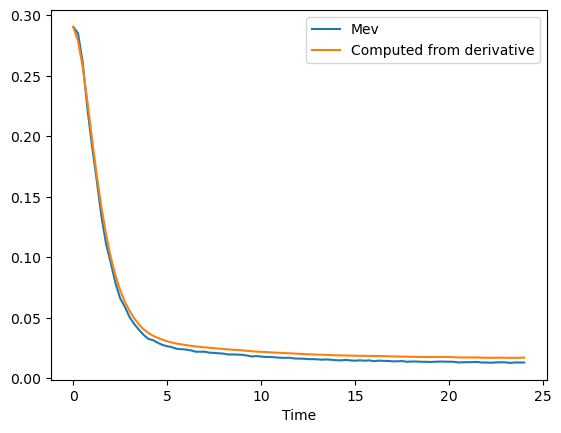

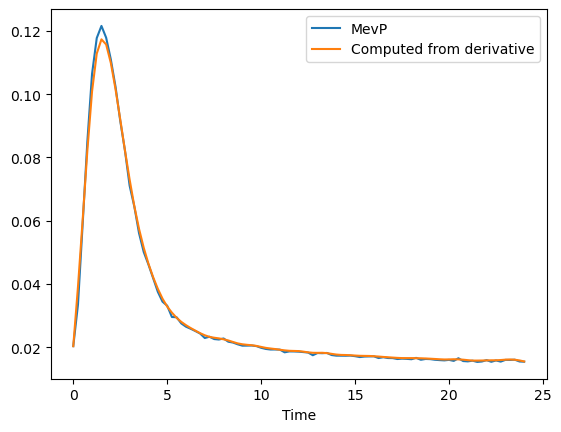

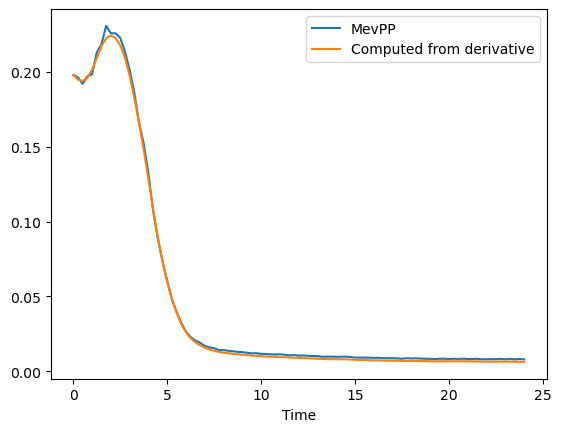

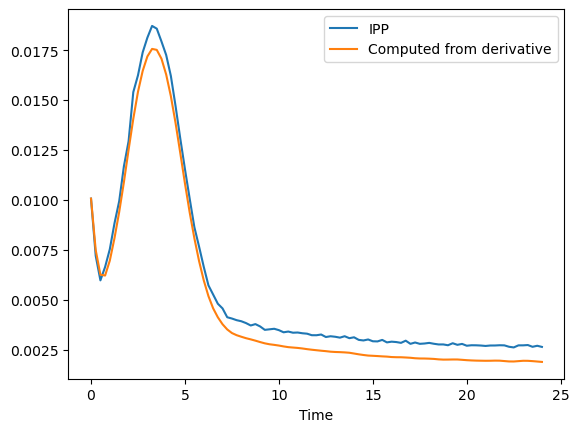

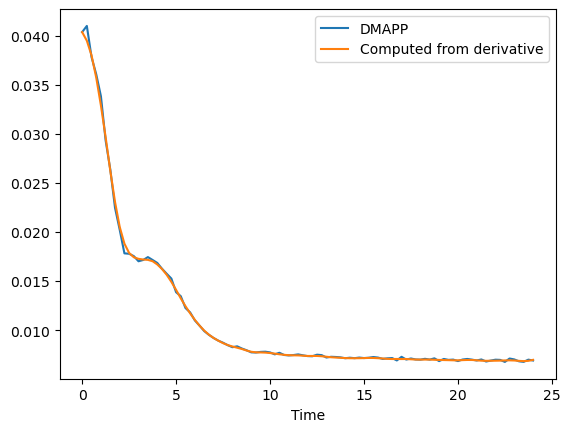

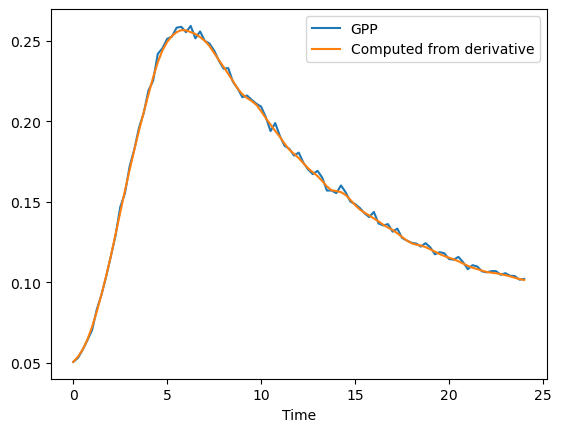

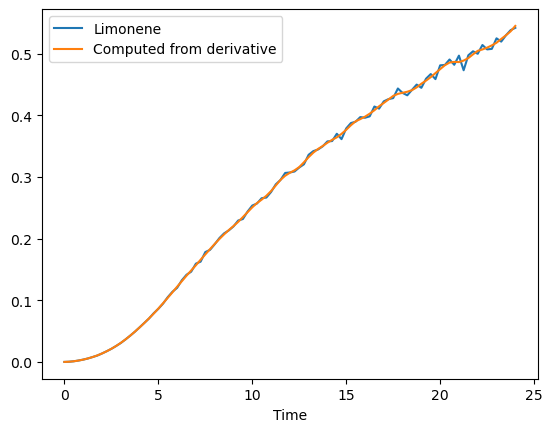

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   6.021797e+01  3.965937e+01  3.688062e+01  5.574897e+01   
         0.25   4.597010e+06  2.294929e+06  2.142199e+05  1.441146e+06   
         0.50   5.451159e+06  3.497433e+06  3.411840e+05  2.236004e+06   
         0.75   5.726004e+06  4.126494e+06  4.088181e+05  2.730130e+06   
         1.00   6.057275e+06  4.578212e+06  4.650788e+05  3.116428e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.793791e+06  2.738508e+06  1.790636e+06  1.966353e+06   
         23.25  2.746174e+06  2.697411e+06  1.756996e+06  2.003719e+06   
         23.50  2.698579e+06  2.671747e+06  1.725002e+06  2.042148e+06   
         23.75  2.757368e+06  2.681689e+06  1.787784e+06  2.026437e+06   
         24.00  2.666181e+06  2.746572e+06  1.769606e+06  1.972738e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.706286e+01  5.388111e+01  5.585060e+01  1.885230e+01   
         0.25   4.699780e+05  2.319278e+06  2.580479e+06  4.355049e+05   
         0.50   7.381283e+05  3.792402e+06  3.246965e+06  6.298491e+05   
         0.75   8.892703e+05  4.747093e+06  3.533031e+06  7.660397e+05   
         1.00   9.754842e+05  5.500615e+06  3.769851e+06  8.493837e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.482486e+06  3.965407e+06  4.311209e+06  1.264628e+06   
         23.25  1.489485e+06  3.960609e+06  4.348569e+06  1.216766e+06   
         23.50  1.458418e+06  3.966576e+06  4.333144e+06  1.247226e+06   
         23.75  1.441278e+06  4.010404e+06  4.335370e+06  1.245131e+06   
         24.00  1.518104e+06  3.997498e+06  4.359388e+06  1.231153e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.061737e+01   0.303775        0.199644  0.049881   
         0.25       1.880093e+05   0.296572        0.199046  0.054568   
         0.50       2.804316e+05   0.297008        0.202129  0.062116   
         0.75       3.543398e+05   0.284511        0.200001  0.069373   
         1.00       4.066978e+05   0.270430        0.193444  0.079186   
...                          ...        ...             ...       ...   
WT       23.00      1.460242e+06   0.367778        0.092700  0.019379   
         23.25      1.473482e+06   0.373861        0.094028  0.019195   
         23.50      1.469301e+06   0.368283        0.094140  0.019805   
         23.75      1.497003e+06   0.374691        0.090554  0.020364   
         24.00      1.463968e+06   0.375006        0.094851  0.019183   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.290244  0.020348  0.197797  0.010068  0.040352  0.050455   
         0.25   0.262964  0.054008  0.191052  0.011460  0.041096  0.053910   
         0.50   0.197535  0.111619  0.178723  0.014108  0.037771  0.064359   
         0.75   0.127909  0.155451  0.176869  0.017358  0.035466  0.079384   
         1.00   0.079888  0.175059  0.170674  0.020551  0.033007  0.096571   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.013157  0.016010  0.007967  0.002724  0.007029  0.105559   
         23.25  0.012698  0.015992  0.008291  0.002739  0.006835  0.103980   
         23.50  0.013077  0.016069  0.007966  0.002651  0.006779 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00    -0.000999        0.014998  0.017983 -0.170104  0.212211   
         0.25    -0.016250        0.005210  0.023675 -0.196206  0.188279   
         0.50    -0.031501       -0.004577  0.029366 -0.222308  0.164346   
         0.75    -0.037502       -0.010023  0.032545 -0.217703  0.117675   
         1.00    -0.050317       -0.017099  0.031136 -0.164298  0.037826   
...                    ...             ...       ...       ...       ...   
WT       23.00   -0.003260        0.001068 -0.000023 -0.000264  0.000397   
         23.25    0.007100        0.000029  0.000748 -0.000207  0.000061   
         23.50    0.006115        0.000331  0.000310  0.000035 -0.000654   
         23.75    0.006372        0.001610 -0.000857  0.000321 -0.001085   
         24.00    0.006630        0.002888 -0.002025  0.000607 -0.001516   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.040599  0.005938 -0.001972  0.010464 -0.000012  
         0.25  -0.033985  0.008342 -0.005050  0.028773  0.000955  
         0.50  -0.027371  0.010746 -0.008128  0.047082  0.001922  
         0.75  -0.019778  0.013118 -0.011251  0.069019  0.002945  
         1.00  -0.021489  0.013323 -0.009715  0.084180  0.004131  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.000107  0.000031 -0.000110 -0.002697  0.022900  
         23.25 -0.000064 -0.000046 -0.000193 -0.003153  0.026160  
         23.50 -0.000045 -0.000077 -0.000022 -0.003833  0.021018  
         23.75 -0.000421 -0.000080  0.000260 -0.002681  0.030487  
         24.00 -0.000796 -0.000082  0.000542 -0.001529  0.039956  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem

# problem definition (object oriented to use population-based approach)
class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=34, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([
                         0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
                         0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
                         0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
                         0.0,0.0,-1.30103,0.0                         
                         ]), # lower bounds
                         xu=np.array([
                         9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,
                         9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,
                         9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,
                         9.0,9.0,-1.301029,9.0
                         ]) # upper bounds
                        )
        
    def _kinetic_model(self, e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                      s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                      k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
                      k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
                      k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
        #HC: 53 parameters (9+10+12+12+10)
        r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
        r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
        r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
        r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
        r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
        r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
        r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
        r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
        r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
        r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
        
        return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]
     
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [29]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [30]:
algo = 'ISRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')

from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e4)

In [31]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=1,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: ISRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 |  4.236671E+29 |  1.002726E+22
     2 |       74 |  4.616869E+18 |  4.651644E+15
     3 |      138 |  1.094687E+16 |  7.801871E+11
     4 |      202 |  4.342222E+13 |  7.801871E+11
     5 |      266 |  1.126922E+13 |  1.216107E+11
     6 |      330 |  4.011548E+11 |  5.331862E+09
     7 |      394 |  3.235355E+11 |  1.525447E+08
     8 |      458 |  1.069064E+10 |  1.525447E+08
     9 |      522 |  1.776294E+09 |  1.598374E+07
    10 |      586 |  5.939701E+08 |  1.598374E+07
    11 |      650 |  1.386634E+08 |  6.276302E+06
    12 |      714 |  2.080612E+08 |  3.550286E+06
    13 |      778 |  1.829421E+08 |  3.550286E+06
    14 |      842 |  6.486119E+07 |  3.550286E+06
    15 |      906 |  3.722475E+07 |  3.550286E+06
    16 |      970 |  4.889081E+07 |  3.550286E+06
    17 |     1034 |  1.402107E+08 |  2.963102E+06
    18 |     1098 |  2.275348E+07 |  1.092279E+06
    19 |     1162 |  9.69

   162 |    10314 |  2.051547E+01 |  1.709896E+01
   163 |    10378 |  2.130959E+01 |  1.709896E+01
   164 |    10442 |  2.001027E+01 |  1.648618E+01
   165 |    10506 |  1.997558E+01 |  1.648618E+01
   166 |    10570 |  2.002465E+01 |  1.648618E+01
   167 |    10634 |  1.964520E+01 |  1.648618E+01
   168 |    10698 |  1.954940E+01 |  1.648618E+01
   169 |    10762 |  1.965341E+01 |  1.648618E+01
   170 |    10826 |  2.012876E+01 |  1.648618E+01
   171 |    10890 |  1.991770E+01 |  1.648618E+01
   172 |    10954 |  1.856266E+01 |  1.648618E+01
   173 |    11018 |  1.858652E+01 |  1.648618E+01
   174 |    11082 |  1.917308E+01 |  1.648618E+01
   175 |    11146 |  1.847396E+01 |  1.603836E+01
   176 |    11210 |  1.744780E+01 |  1.540695E+01
   177 |    11274 |  1.682868E+01 |  1.411869E+01
   178 |    11338 |  1.714993E+01 |  1.411869E+01
   179 |    11402 |  1.727902E+01 |  1.411869E+01
   180 |    11466 |  1.703970E+01 |  1.411869E+01
   181 |    11530 |  1.689146E+01 |  1.411869E+01


   326 |    20810 |  6.7511338262 |  6.4343142822
   327 |    20874 |  6.7033811140 |  6.4343142822
   328 |    20938 |  6.6973076505 |  6.4343142822
   329 |    21002 |  6.6457135181 |  6.4343142822
   330 |    21066 |  6.5903797260 |  6.3869906273
   331 |    21130 |  6.5583617832 |  6.3869906273
   332 |    21194 |  6.4928380829 |  6.3869906273
   333 |    21258 |  6.4799469435 |  6.3869906273
   334 |    21322 |  6.5195080460 |  6.3869906273
   335 |    21386 |  6.4990383423 |  6.3869906273
   336 |    21450 |  6.4757678553 |  6.3866345989
   337 |    21514 |  6.4865764190 |  6.3624605847
   338 |    21578 |  6.4755158212 |  6.2954602746
   339 |    21642 |  6.4674284023 |  6.2954602746
   340 |    21706 |  6.4407798198 |  6.2954602746
   341 |    21770 |  6.4152164675 |  6.2954602746
   342 |    21834 |  6.4474664148 |  6.2954602746
   343 |    21898 |  6.4256254098 |  6.2919342615
   344 |    21962 |  6.4079652048 |  6.2826916313
   345 |    22026 |  6.4057009848 |  6.2826916313


   490 |    31306 |  4.9466464585 |  4.9287152290
   491 |    31370 |  4.9405691558 |  4.9264887347
   492 |    31434 |  4.9271479660 |  4.9242794584
   493 |    31498 |  4.9067931428 |  4.8634935693
   494 |    31562 |  4.8739505379 |  4.8586654593
   495 |    31626 |  4.8295140339 |  4.7894111827
   496 |    31690 |  4.7966739096 |  4.7608209880
   497 |    31754 |  4.7662402122 |  4.7364373607
   498 |    31818 |  4.7473692345 |  4.7351129138
   499 |    31882 |  4.7434572011 |  4.7306647052
   500 |    31946 |  4.7353732884 |  4.7176277747
   501 |    32010 |  4.7248825887 |  4.7146805159
   502 |    32074 |  4.7186443579 |  4.6977631557
   503 |    32138 |  4.7123406971 |  4.6920855006
   504 |    32202 |  4.7044675811 |  4.6920855006
   505 |    32266 |  4.7039421078 |  4.6920855006
   506 |    32330 |  4.7035511199 |  4.6920855006
   507 |    32394 |  4.6982717039 |  4.6899277143
   508 |    32458 |  4.6798396715 |  4.6629645939
   509 |    32522 |  4.6624426010 |  4.6300491708


   654 |    41802 |  3.9312533064 |  3.9280794759
   655 |    41866 |  3.9313775072 |  3.9280794759
   656 |    41930 |  3.9316205973 |  3.9280794759
   657 |    41994 |  3.9329821938 |  3.9280794759
   658 |    42058 |  3.9305743887 |  3.9280794759
   659 |    42122 |  3.9298696938 |  3.9273409390
   660 |    42186 |  3.9295262393 |  3.9266342806
   661 |    42250 |  3.9285067209 |  3.9265197946
   662 |    42314 |  3.9282475883 |  3.9256162303
   663 |    42378 |  3.9275128341 |  3.9247974190
   664 |    42442 |  3.9264746006 |  3.9240883639
   665 |    42506 |  3.9261355615 |  3.9240883639
   666 |    42570 |  3.9253688986 |  3.9234948048
   667 |    42634 |  3.9248196745 |  3.9234948048
   668 |    42698 |  3.9248944758 |  3.9219118437
   669 |    42762 |  3.9246427804 |  3.9219118437
   670 |    42826 |  3.9240535216 |  3.9214748765
   671 |    42890 |  3.9232458219 |  3.9212577872
   672 |    42954 |  3.9235543326 |  3.9212577872
   673 |    43018 |  3.9223049656 |  3.9206664572


   818 |    52298 |  3.8939990479 |  3.8939196849
   819 |    52362 |  3.8939753328 |  3.8937610581
   820 |    52426 |  3.8939046767 |  3.8937610581
   821 |    52490 |  3.8938817263 |  3.8937610581
   822 |    52554 |  3.8939009060 |  3.8937610581
   823 |    52618 |  3.8938781200 |  3.8937610581
   824 |    52682 |  3.8938734712 |  3.8937610581
   825 |    52746 |  3.8938592230 |  3.8937610581
   826 |    52810 |  3.8938904566 |  3.8937610581
   827 |    52874 |  3.8939200310 |  3.8937610581
   828 |    52938 |  3.8938172642 |  3.8936316665
   829 |    53002 |  3.8937469648 |  3.8936316665
   830 |    53066 |  3.8937534788 |  3.8936316665
   831 |    53130 |  3.8936971719 |  3.8935390674
   832 |    53194 |  3.8937182769 |  3.8935390674
   833 |    53258 |  3.8937164890 |  3.8935390674
   834 |    53322 |  3.8937171519 |  3.8935390674
   835 |    53386 |  3.8936700681 |  3.8935390674
   836 |    53450 |  3.8936397903 |  3.8935390674
   837 |    53514 |  3.8935908495 |  3.8935390674


   982 |    62794 |  3.8926301268 |  3.8926159464
   983 |    62858 |  3.8926197313 |  3.8926134497
   984 |    62922 |  3.8926094103 |  3.8925974252
   985 |    62986 |  3.8926038467 |  3.8925927822
   986 |    63050 |  3.8926029896 |  3.8925927822
   987 |    63114 |  3.8925992895 |  3.8925838125
   988 |    63178 |  3.8926029736 |  3.8925838125
   989 |    63242 |  3.8925969022 |  3.8925812765
   990 |    63306 |  3.8925982866 |  3.8925804541
   991 |    63370 |  3.8925876426 |  3.8925558850
   992 |    63434 |  3.8925720877 |  3.8925558850
   993 |    63498 |  3.8925603044 |  3.8925483710
   994 |    63562 |  3.8925523003 |  3.8925186577
   995 |    63626 |  3.8925310593 |  3.8925184499
   996 |    63690 |  3.8925268944 |  3.8925184499
   997 |    63754 |  3.8925293100 |  3.8925184499
   998 |    63818 |  3.8925251447 |  3.8925106215
   999 |    63882 |  3.8925204436 |  3.8925105673
  1000 |    63946 |  3.8925189567 |  3.8925073756
  1001 |    64010 |  3.8925145913 |  3.8924933296


  1146 |    73290 |  3.8922889278 |  3.8919763166
  1147 |    73354 |  3.8918367246 |  3.8914943993
  1148 |    73418 |  3.8911587489 |  3.8911047152
  1149 |    73482 |  3.8911228442 |  3.8910606246
  1150 |    73546 |  3.8910853556 |  3.8910433540
  1151 |    73610 |  3.8910417066 |  3.8910172244
  1152 |    73674 |  3.8910242442 |  3.8909587148
  1153 |    73738 |  3.8909653749 |  3.8908944090
  1154 |    73802 |  3.8909238324 |  3.8908259801
  1155 |    73866 |  3.8908539243 |  3.8907725752
  1156 |    73930 |  3.8907873015 |  3.8906725477
  1157 |    73994 |  3.8906923414 |  3.8905330812
  1158 |    74058 |  3.8906553846 |  3.8905330812
  1159 |    74122 |  3.8906387597 |  3.8905155232
  1160 |    74186 |  3.8905339112 |  3.8904467872
  1161 |    74250 |  3.8904332389 |  3.8903325221
  1162 |    74314 |  3.8902532770 |  3.8899259892
  1163 |    74378 |  3.8899531248 |  3.8897937801
  1164 |    74442 |  3.8897424753 |  3.8896521883
  1165 |    74506 |  3.8895116393 |  3.8894366252


  1310 |    83786 |  3.8829315138 |  3.8829253789
  1311 |    83850 |  3.8829311598 |  3.8829253789
  1312 |    83914 |  3.8829325641 |  3.8829253789
  1313 |    83978 |  3.8829305545 |  3.8829253789
  1314 |    84042 |  3.8829284074 |  3.8829225029
  1315 |    84106 |  3.8829270443 |  3.8829225029
  1316 |    84170 |  3.8829271420 |  3.8829201865
  1317 |    84234 |  3.8829274382 |  3.8829201865
  1318 |    84298 |  3.8829274182 |  3.8829201865
  1319 |    84362 |  3.8829259278 |  3.8829201865
  1320 |    84426 |  3.8829254853 |  3.8829201865
  1321 |    84490 |  3.8829245590 |  3.8829197610
  1322 |    84554 |  3.8829237961 |  3.8829196895
  1323 |    84618 |  3.8829212960 |  3.8829175869
  1324 |    84682 |  3.8829218904 |  3.8829175869
  1325 |    84746 |  3.8829203230 |  3.8829160923
  1326 |    84810 |  3.8829192631 |  3.8829157771
  1327 |    84874 |  3.8829171456 |  3.8829125462
  1328 |    84938 |  3.8829170925 |  3.8829125462
  1329 |    85002 |  3.8829166954 |  3.8829125462


  1474 |    94282 |  3.8498441246 |  3.8488114021
  1475 |    94346 |  3.8482798424 |  3.8475936193
  1476 |    94410 |  3.8466266292 |  3.8395951041
  1477 |    94474 |  3.8392204121 |  3.8362557754
  1478 |    94538 |  3.8344322684 |  3.8306368785
  1479 |    94602 |  3.8297364191 |  3.8273287676
  1480 |    94666 |  3.8265608002 |  3.8226012641
  1481 |    94730 |  3.8232514727 |  3.8204448187
  1482 |    94794 |  3.8203766871 |  3.8098688544
  1483 |    94858 |  3.8099210471 |  3.8060077846
  1484 |    94922 |  3.8071588809 |  3.8055273808
  1485 |    94986 |  3.8041383826 |  3.7999643762
  1486 |    95050 |  3.7992052192 |  3.7957699044
  1487 |    95114 |  3.7959253589 |  3.7908008020
  1488 |    95178 |  3.7908428544 |  3.7883278202
  1489 |    95242 |  3.7880794103 |  3.7853586894
  1490 |    95306 |  3.7852703061 |  3.7840363505
  1491 |    95370 |  3.7813661607 |  3.7751582616
  1492 |    95434 |  3.7761757408 |  3.7734191718
  1493 |    95498 |  3.7742343499 |  3.7734191718


  1638 |   104778 |  3.7691477149 |  3.7691469544
  1639 |   104842 |  3.7691474583 |  3.7691469544
  1640 |   104906 |  3.7691473753 |  3.7691468182
  1641 |   104970 |  3.7691471138 |  3.7691466930
  1642 |   105034 |  3.7691473281 |  3.7691466930
  1643 |   105098 |  3.7691473014 |  3.7691466930
  1644 |   105162 |  3.7691468400 |  3.7691462619
  1645 |   105226 |  3.7691465471 |  3.7691456721
  1646 |   105290 |  3.7691462080 |  3.7691453380
  1647 |   105354 |  3.7691461067 |  3.7691453380
  1648 |   105418 |  3.7691459196 |  3.7691451543
  1649 |   105482 |  3.7691455578 |  3.7691448851
  1650 |   105546 |  3.7691453722 |  3.7691445958
  1651 |   105610 |  3.7691452356 |  3.7691445958
  1652 |   105674 |  3.7691450008 |  3.7691441186
  1653 |   105738 |  3.7691446721 |  3.7691441186
  1654 |   105802 |  3.7691443602 |  3.7691438184
  1655 |   105866 |  3.7691440131 |  3.7691434676
  1656 |   105930 |  3.7691438237 |  3.7691434568
  1657 |   105994 |  3.7691438410 |  3.7691434568


  1802 |   115274 |  3.7691346060 |  3.7691345065
  1803 |   115338 |  3.7691345800 |  3.7691344931
  1804 |   115402 |  3.7691344208 |  3.7691341230
  1805 |   115466 |  3.7691342343 |  3.7691340487
  1806 |   115530 |  3.7691340795 |  3.7691339766
  1807 |   115594 |  3.7691339560 |  3.7691338256
  1808 |   115658 |  3.7691338681 |  3.7691337285
  1809 |   115722 |  3.7691336984 |  3.7691333933
  1810 |   115786 |  3.7691334805 |  3.7691332627
  1811 |   115850 |  3.7691333174 |  3.7691330258
  1812 |   115914 |  3.7691330709 |  3.7691328834
  1813 |   115978 |  3.7691328947 |  3.7691326301
  1814 |   116042 |  3.7691325151 |  3.7691319594
  1815 |   116106 |  3.7691318758 |  3.7691313514
  1816 |   116170 |  3.7691314893 |  3.7691312564
  1817 |   116234 |  3.7691313898 |  3.7691311645
  1818 |   116298 |  3.7691312040 |  3.7691308821
  1819 |   116362 |  3.7691309500 |  3.7691305886
  1820 |   116426 |  3.7691304992 |  3.7691301129
  1821 |   116490 |  3.7691300914 |  3.7691295543


  1966 |   125770 |  3.7690610519 |  3.7690608362
  1967 |   125834 |  3.7690609567 |  3.7690607022
  1968 |   125898 |  3.7690608571 |  3.7690606108
  1969 |   125962 |  3.7690607412 |  3.7690605697
  1970 |   126026 |  3.7690607290 |  3.7690605697
  1971 |   126090 |  3.7690607529 |  3.7690605697
  1972 |   126154 |  3.7690607538 |  3.7690605697
  1973 |   126218 |  3.7690607106 |  3.7690605697
  1974 |   126282 |  3.7690606890 |  3.7690604453
  1975 |   126346 |  3.7690605817 |  3.7690604453
  1976 |   126410 |  3.7690604882 |  3.7690603871
  1977 |   126474 |  3.7690605041 |  3.7690603871
  1978 |   126538 |  3.7690604454 |  3.7690602350
  1979 |   126602 |  3.7690602445 |  3.7690599355
  1980 |   126666 |  3.7690601801 |  3.7690598838
  1981 |   126730 |  3.7690600723 |  3.7690598838
  1982 |   126794 |  3.7690599108 |  3.7690597975
  1983 |   126858 |  3.7690597770 |  3.7690595370
  1984 |   126922 |  3.7690596549 |  3.7690594512
  1985 |   126986 |  3.7690596084 |  3.7690594335


  2130 |   136266 |  3.7690376057 |  3.7690375756
  2131 |   136330 |  3.7690375985 |  3.7690375756
  2132 |   136394 |  3.7690375906 |  3.7690375702
  2133 |   136458 |  3.7690375794 |  3.7690375681
  2134 |   136522 |  3.7690375701 |  3.7690375520
  2135 |   136586 |  3.7690375638 |  3.7690375520
  2136 |   136650 |  3.7690375656 |  3.7690375444
  2137 |   136714 |  3.7690375676 |  3.7690375444
  2138 |   136778 |  3.7690375649 |  3.7690375444
  2139 |   136842 |  3.7690375621 |  3.7690375444
  2140 |   136906 |  3.7690375645 |  3.7690375444
  2141 |   136970 |  3.7690375641 |  3.7690375444
  2142 |   137034 |  3.7690375654 |  3.7690375444
  2143 |   137098 |  3.7690375633 |  3.7690375444
  2144 |   137162 |  3.7690375593 |  3.7690375444
  2145 |   137226 |  3.7690375565 |  3.7690375444
  2146 |   137290 |  3.7690375536 |  3.7690375444
  2147 |   137354 |  3.7690375541 |  3.7690375444
  2148 |   137418 |  3.7690375569 |  3.7690375444
  2149 |   137482 |  3.7690375553 |  3.7690375444


  2294 |   146762 |  3.7690374191 |  3.7690374188
  2295 |   146826 |  3.7690374191 |  3.7690374186
  2296 |   146890 |  3.7690374189 |  3.7690374185
  2297 |   146954 |  3.7690374190 |  3.7690374185
  2298 |   147018 |  3.7690374189 |  3.7690374185
  2299 |   147082 |  3.7690374189 |  3.7690374185
  2300 |   147146 |  3.7690374186 |  3.7690374185
  2301 |   147210 |  3.7690374186 |  3.7690374185
  2302 |   147274 |  3.7690374186 |  3.7690374184
  2303 |   147338 |  3.7690374184 |  3.7690374183
  2304 |   147402 |  3.7690374184 |  3.7690374180
  2305 |   147466 |  3.7690374182 |  3.7690374179
  2306 |   147530 |  3.7690374181 |  3.7690374179
  2307 |   147594 |  3.7690374179 |  3.7690374178
  2308 |   147658 |  3.7690374179 |  3.7690374177
  2309 |   147722 |  3.7690374178 |  3.7690374176
  2310 |   147786 |  3.7690374177 |  3.7690374175
  2311 |   147850 |  3.7690374175 |  3.7690374174
  2312 |   147914 |  3.7690374174 |  3.7690374174
  2313 |   147978 |  3.7690374174 |  3.7690374173


  2458 |   157258 |  3.7690373949 |  3.7690373934
  2459 |   157322 |  3.7690373935 |  3.7690373906
  2460 |   157386 |  3.7690373917 |  3.7690373899
  2461 |   157450 |  3.7690373901 |  3.7690373895
  2462 |   157514 |  3.7690373897 |  3.7690373882
  2463 |   157578 |  3.7690373882 |  3.7690373856
  2464 |   157642 |  3.7690373867 |  3.7690373855
  2465 |   157706 |  3.7690373853 |  3.7690373840
  2466 |   157770 |  3.7690373847 |  3.7690373840
  2467 |   157834 |  3.7690373844 |  3.7690373833
  2468 |   157898 |  3.7690373839 |  3.7690373833
  2469 |   157962 |  3.7690373836 |  3.7690373827
  2470 |   158026 |  3.7690373835 |  3.7690373822
  2471 |   158090 |  3.7690373826 |  3.7690373810
  2472 |   158154 |  3.7690373824 |  3.7690373810
  2473 |   158218 |  3.7690373825 |  3.7690373810
  2474 |   158282 |  3.7690373823 |  3.7690373810
  2475 |   158346 |  3.7690373818 |  3.7690373810
  2476 |   158410 |  3.7690373816 |  3.7690373799
  2477 |   158474 |  3.7690373810 |  3.7690373796


  2622 |   167754 |  3.7690373571 |  3.7690373571
  2623 |   167818 |  3.7690373571 |  3.7690373571
  2624 |   167882 |  3.7690373571 |  3.7690373571
  2625 |   167946 |  3.7690373571 |  3.7690373571
  2626 |   168010 |  3.7690373571 |  3.7690373571
  2627 |   168074 |  3.7690373571 |  3.7690373570
  2628 |   168138 |  3.7690373570 |  3.7690373570
  2629 |   168202 |  3.7690373570 |  3.7690373570
  2630 |   168266 |  3.7690373570 |  3.7690373570
  2631 |   168330 |  3.7690373570 |  3.7690373570
  2632 |   168394 |  3.7690373570 |  3.7690373570
  2633 |   168458 |  3.7690373570 |  3.7690373570
  2634 |   168522 |  3.7690373570 |  3.7690373570
  2635 |   168586 |  3.7690373570 |  3.7690373570
  2636 |   168650 |  3.7690373570 |  3.7690373570
  2637 |   168714 |  3.7690373570 |  3.7690373570
  2638 |   168778 |  3.7690373570 |  3.7690373569
  2639 |   168842 |  3.7690373570 |  3.7690373569
  2640 |   168906 |  3.7690373570 |  3.7690373569
  2641 |   168970 |  3.7690373570 |  3.7690373569


  2786 |   178250 |  3.7690373565 |  3.7690373565
  2787 |   178314 |  3.7690373565 |  3.7690373565
  2788 |   178378 |  3.7690373565 |  3.7690373565
  2789 |   178442 |  3.7690373565 |  3.7690373565
  2790 |   178506 |  3.7690373565 |  3.7690373565
  2791 |   178570 |  3.7690373565 |  3.7690373565
  2792 |   178634 |  3.7690373565 |  3.7690373565
  2793 |   178698 |  3.7690373565 |  3.7690373565
  2794 |   178762 |  3.7690373565 |  3.7690373565
  2795 |   178826 |  3.7690373565 |  3.7690373565
  2796 |   178890 |  3.7690373565 |  3.7690373565
  2797 |   178954 |  3.7690373565 |  3.7690373565
  2798 |   179018 |  3.7690373565 |  3.7690373565
  2799 |   179082 |  3.7690373565 |  3.7690373565
  2800 |   179146 |  3.7690373565 |  3.7690373565
  2801 |   179210 |  3.7690373565 |  3.7690373565
  2802 |   179274 |  3.7690373565 |  3.7690373565
  2803 |   179338 |  3.7690373565 |  3.7690373565
  2804 |   179402 |  3.7690373565 |  3.7690373565
  2805 |   179466 |  3.7690373565 |  3.7690373565


  2950 |   188746 |  3.7690373564 |  3.7690373564
  2951 |   188810 |  3.7690373564 |  3.7690373564
  2952 |   188874 |  3.7690373564 |  3.7690373564
  2953 |   188938 |  3.7690373564 |  3.7690373564
  2954 |   189002 |  3.7690373564 |  3.7690373564
  2955 |   189066 |  3.7690373564 |  3.7690373564
  2956 |   189130 |  3.7690373564 |  3.7690373564
  2957 |   189194 |  3.7690373564 |  3.7690373564
  2958 |   189258 |  3.7690373564 |  3.7690373564
  2959 |   189322 |  3.7690373564 |  3.7690373564
  2960 |   189386 |  3.7690373564 |  3.7690373564
  2961 |   189450 |  3.7690373564 |  3.7690373563
  2962 |   189514 |  3.7690373563 |  3.7690373563
  2963 |   189578 |  3.7690373563 |  3.7690373563
  2964 |   189642 |  3.7690373563 |  3.7690373563
  2965 |   189706 |  3.7690373563 |  3.7690373563
  2966 |   189770 |  3.7690373563 |  3.7690373563
  2967 |   189834 |  3.7690373563 |  3.7690373563
  2968 |   189898 |  3.7690373563 |  3.7690373563
  2969 |   189962 |  3.7690373563 |  3.7690373563


  3114 |   199242 |  3.7659218679 |  3.7659008985
  3115 |   199306 |  3.7659021345 |  3.7658954033
  3116 |   199370 |  3.7658965328 |  3.7658953191
  3117 |   199434 |  3.7658954952 |  3.7658951597
  3118 |   199498 |  3.7658951813 |  3.7658948594
  3119 |   199562 |  3.7658944858 |  3.7658934855
  3120 |   199626 |  3.7658936482 |  3.7658931263
  3121 |   199690 |  3.7658931661 |  3.7658923963
  3122 |   199754 |  3.7658917704 |  3.7658855413
  3123 |   199818 |  3.7658864990 |  3.7658845059
  3124 |   199882 |  3.7658840404 |  3.7658830530
  3125 |   199946 |  3.7658797844 |  3.7658772745
  3126 |   200010 |  3.7658751700 |  3.7658723337
  3127 |   200074 |  3.7658715625 |  3.7658680072
  3128 |   200138 |  3.7658665523 |  3.7658636166
  3129 |   200202 |  3.7658629667 |  3.7658586861
  3130 |   200266 |  3.7658566572 |  3.7658464660
  3131 |   200330 |  3.7658435409 |  3.7658350810
  3132 |   200394 |  3.7658315510 |  3.7658205403
  3133 |   200458 |  3.7658202462 |  3.7658134909


  3278 |   209738 |  3.7514621330 |  3.7514112727
  3279 |   209802 |  3.7514143017 |  3.7513674379
  3280 |   209866 |  3.7513738581 |  3.7513051000
  3281 |   209930 |  3.7513361318 |  3.7512995788
  3282 |   209994 |  3.7513114342 |  3.7512669907
  3283 |   210058 |  3.7512820075 |  3.7512482147
  3284 |   210122 |  3.7512454844 |  3.7511988732
  3285 |   210186 |  3.7511931366 |  3.7511773798
  3286 |   210250 |  3.7511601455 |  3.7510694545
  3287 |   210314 |  3.7511160804 |  3.7510694545
  3288 |   210378 |  3.7510744499 |  3.7510437542
  3289 |   210442 |  3.7510472967 |  3.7509936305
  3290 |   210506 |  3.7509979338 |  3.7509563476
  3291 |   210570 |  3.7509631625 |  3.7509314719
  3292 |   210634 |  3.7509345717 |  3.7508920851
  3293 |   210698 |  3.7509069300 |  3.7508814537
  3294 |   210762 |  3.7508866245 |  3.7508319206
  3295 |   210826 |  3.7508568466 |  3.7507429349
  3296 |   210890 |  3.7508033052 |  3.7507429349
  3297 |   210954 |  3.7507678168 |  3.7506966378


  3442 |   220234 |  3.7470346572 |  3.7470152057
  3443 |   220298 |  3.7470313083 |  3.7470103562
  3444 |   220362 |  3.7470271768 |  3.7470082329
  3445 |   220426 |  3.7470200993 |  3.7470014938
  3446 |   220490 |  3.7470150330 |  3.7470012990
  3447 |   220554 |  3.7470161531 |  3.7469947343
  3448 |   220618 |  3.7470098099 |  3.7469929613
  3449 |   220682 |  3.7470077096 |  3.7469929613
  3450 |   220746 |  3.7470067420 |  3.7469929613
  3451 |   220810 |  3.7469993087 |  3.7469853248
  3452 |   220874 |  3.7469932285 |  3.7469728474
  3453 |   220938 |  3.7469809238 |  3.7469554648
  3454 |   221002 |  3.7469779227 |  3.7469515109
  3455 |   221066 |  3.7469718362 |  3.7469465160
  3456 |   221130 |  3.7469632163 |  3.7469342764
  3457 |   221194 |  3.7469491607 |  3.7469338026
  3458 |   221258 |  3.7469380316 |  3.7469243692
  3459 |   221322 |  3.7469297428 |  3.7469185486
  3460 |   221386 |  3.7469254330 |  3.7468967039
  3461 |   221450 |  3.7469123493 |  3.7468967039


  3606 |   230730 |  3.7462914488 |  3.7462873691
  3607 |   230794 |  3.7462898680 |  3.7462865270
  3608 |   230858 |  3.7462877085 |  3.7462789279
  3609 |   230922 |  3.7462859501 |  3.7462789279
  3610 |   230986 |  3.7462823838 |  3.7462784545
  3611 |   231050 |  3.7462801455 |  3.7462777023
  3612 |   231114 |  3.7462800460 |  3.7462769267
  3613 |   231178 |  3.7462759340 |  3.7462710330
  3614 |   231242 |  3.7462727491 |  3.7462683389
  3615 |   231306 |  3.7462699621 |  3.7462674844
  3616 |   231370 |  3.7462697627 |  3.7462671789
  3617 |   231434 |  3.7462688043 |  3.7462647721
  3618 |   231498 |  3.7462678820 |  3.7462647721
  3619 |   231562 |  3.7462673231 |  3.7462640125
  3620 |   231626 |  3.7462669380 |  3.7462640125
  3621 |   231690 |  3.7462652838 |  3.7462623080
  3622 |   231754 |  3.7462636678 |  3.7462600210
  3623 |   231818 |  3.7462611438 |  3.7462594041
  3624 |   231882 |  3.7462602771 |  3.7462581527
  3625 |   231946 |  3.7462588364 |  3.7462566826


  3770 |   241226 |  3.7461207400 |  3.7461193503
  3771 |   241290 |  3.7461202672 |  3.7461192959
  3772 |   241354 |  3.7461199947 |  3.7461192479
  3773 |   241418 |  3.7461195210 |  3.7461187909
  3774 |   241482 |  3.7461190724 |  3.7461186356
  3775 |   241546 |  3.7461189216 |  3.7461183880
  3776 |   241610 |  3.7461187834 |  3.7461183210
  3777 |   241674 |  3.7461184618 |  3.7461181873
  3778 |   241738 |  3.7461186538 |  3.7461178484
  3779 |   241802 |  3.7461181468 |  3.7461175982
  3780 |   241866 |  3.7461180345 |  3.7461175982
  3781 |   241930 |  3.7461182249 |  3.7461175982
  3782 |   241994 |  3.7461180535 |  3.7461173675
  3783 |   242058 |  3.7461176893 |  3.7461172801
  3784 |   242122 |  3.7461173675 |  3.7461169502
  3785 |   242186 |  3.7461172489 |  3.7461164653
  3786 |   242250 |  3.7461169876 |  3.7461163086
  3787 |   242314 |  3.7461167664 |  3.7461160720
  3788 |   242378 |  3.7461162550 |  3.7461152277
  3789 |   242442 |  3.7461157977 |  3.7461148002


  3934 |   251722 |  3.7461068910 |  3.7461068495
  3935 |   251786 |  3.7461068877 |  3.7461068387
  3936 |   251850 |  3.7461068431 |  3.7461067581
  3937 |   251914 |  3.7461068102 |  3.7461067581
  3938 |   251978 |  3.7461067971 |  3.7461067410
  3939 |   252042 |  3.7461067491 |  3.7461066481
  3940 |   252106 |  3.7461067239 |  3.7461066481
  3941 |   252170 |  3.7461066709 |  3.7461066057
  3942 |   252234 |  3.7461066297 |  3.7461066044
  3943 |   252298 |  3.7461066201 |  3.7461065775
  3944 |   252362 |  3.7461065942 |  3.7461065691
  3945 |   252426 |  3.7461065858 |  3.7461065626
  3946 |   252490 |  3.7461065841 |  3.7461065451
  3947 |   252554 |  3.7461065552 |  3.7461065176
  3948 |   252618 |  3.7461065335 |  3.7461064914
  3949 |   252682 |  3.7461065162 |  3.7461064914
  3950 |   252746 |  3.7461064988 |  3.7461064492
  3951 |   252810 |  3.7461064946 |  3.7461064410
  3952 |   252874 |  3.7461064665 |  3.7461064320
  3953 |   252938 |  3.7461064094 |  3.7461063131


  4098 |   262218 |  3.7460966688 |  3.7460965722
  4099 |   262282 |  3.7460966552 |  3.7460965722
  4100 |   262346 |  3.7460965798 |  3.7460964520
  4101 |   262410 |  3.7460965703 |  3.7460964520
  4102 |   262474 |  3.7460965581 |  3.7460964520
  4103 |   262538 |  3.7460965066 |  3.7460964340
  4104 |   262602 |  3.7460965032 |  3.7460964133
  4105 |   262666 |  3.7460964681 |  3.7460963747
  4106 |   262730 |  3.7460964458 |  3.7460963376
  4107 |   262794 |  3.7460963650 |  3.7460963002
  4108 |   262858 |  3.7460963195 |  3.7460962210
  4109 |   262922 |  3.7460963164 |  3.7460962210
  4110 |   262986 |  3.7460962653 |  3.7460961930
  4111 |   263050 |  3.7460962050 |  3.7460961475
  4112 |   263114 |  3.7460961729 |  3.7460960591
  4113 |   263178 |  3.7460961241 |  3.7460960375
  4114 |   263242 |  3.7460961162 |  3.7460959886
  4115 |   263306 |  3.7460960638 |  3.7460959886
  4116 |   263370 |  3.7460960167 |  3.7460958353
  4117 |   263434 |  3.7460959328 |  3.7460958353


  4262 |   272714 |  3.7460815614 |  3.7460815264
  4263 |   272778 |  3.7460815549 |  3.7460814931
  4264 |   272842 |  3.7460815291 |  3.7460814899
  4265 |   272906 |  3.7460815229 |  3.7460814823
  4266 |   272970 |  3.7460815036 |  3.7460814646
  4267 |   273034 |  3.7460814860 |  3.7460814443
  4268 |   273098 |  3.7460814690 |  3.7460814347
  4269 |   273162 |  3.7460814588 |  3.7460814329
  4270 |   273226 |  3.7460814758 |  3.7460814242
  4271 |   273290 |  3.7460814753 |  3.7460814164
  4272 |   273354 |  3.7460814440 |  3.7460813733
  4273 |   273418 |  3.7460814328 |  3.7460813556
  4274 |   273482 |  3.7460814394 |  3.7460813556
  4275 |   273546 |  3.7460814064 |  3.7460812993
  4276 |   273610 |  3.7460813909 |  3.7460812993
  4277 |   273674 |  3.7460813391 |  3.7460812993
  4278 |   273738 |  3.7460813519 |  3.7460812970
  4279 |   273802 |  3.7460812948 |  3.7460812150
  4280 |   273866 |  3.7460812701 |  3.7460812150
  4281 |   273930 |  3.7460812495 |  3.7460811867


  4426 |   283210 |  3.7460805403 |  3.7460805284
  4427 |   283274 |  3.7460805169 |  3.7460804821
  4428 |   283338 |  3.7460804830 |  3.7460804427
  4429 |   283402 |  3.7460804444 |  3.7460804043
  4430 |   283466 |  3.7460804147 |  3.7460803905
  4431 |   283530 |  3.7460803918 |  3.7460803770
  4432 |   283594 |  3.7460803813 |  3.7460803600
  4433 |   283658 |  3.7460803686 |  3.7460803565
  4434 |   283722 |  3.7460803453 |  3.7460803183
  4435 |   283786 |  3.7460803316 |  3.7460803080
  4436 |   283850 |  3.7460803111 |  3.7460802793
  4437 |   283914 |  3.7460802922 |  3.7460802710
  4438 |   283978 |  3.7460802754 |  3.7460802177
  4439 |   284042 |  3.7460802301 |  3.7460801970
  4440 |   284106 |  3.7460802067 |  3.7460801762
  4441 |   284170 |  3.7460801866 |  3.7460801713
  4442 |   284234 |  3.7460801780 |  3.7460801338
  4443 |   284298 |  3.7460801488 |  3.7460801181
  4444 |   284362 |  3.7460801258 |  3.7460800836
  4445 |   284426 |  3.7460800821 |  3.7460800379


  4590 |   293706 |  3.7460796964 |  3.7460796952
  4591 |   293770 |  3.7460796957 |  3.7460796952
  4592 |   293834 |  3.7460796955 |  3.7460796952
  4593 |   293898 |  3.7460796952 |  3.7460796949
  4594 |   293962 |  3.7460796951 |  3.7460796944
  4595 |   294026 |  3.7460796949 |  3.7460796944
  4596 |   294090 |  3.7460796947 |  3.7460796943
  4597 |   294154 |  3.7460796945 |  3.7460796942
  4598 |   294218 |  3.7460796943 |  3.7460796933
  4599 |   294282 |  3.7460796942 |  3.7460796933
  4600 |   294346 |  3.7460796936 |  3.7460796928
  4601 |   294410 |  3.7460796933 |  3.7460796927
  4602 |   294474 |  3.7460796928 |  3.7460796924
  4603 |   294538 |  3.7460796927 |  3.7460796923
  4604 |   294602 |  3.7460796924 |  3.7460796919
  4605 |   294666 |  3.7460796921 |  3.7460796917
  4606 |   294730 |  3.7460796917 |  3.7460796915
  4607 |   294794 |  3.7460796916 |  3.7460796911
  4608 |   294858 |  3.7460796915 |  3.7460796910
  4609 |   294922 |  3.7460796914 |  3.7460796908


  4754 |   304202 |  3.7460796649 |  3.7460796648
  4755 |   304266 |  3.7460796649 |  3.7460796648
  4756 |   304330 |  3.7460796649 |  3.7460796648
  4757 |   304394 |  3.7460796648 |  3.7460796648
  4758 |   304458 |  3.7460796648 |  3.7460796646
  4759 |   304522 |  3.7460796647 |  3.7460796646
  4760 |   304586 |  3.7460796646 |  3.7460796645
  4761 |   304650 |  3.7460796646 |  3.7460796645
  4762 |   304714 |  3.7460796646 |  3.7460796645
  4763 |   304778 |  3.7460796645 |  3.7460796645
  4764 |   304842 |  3.7460796645 |  3.7460796645
  4765 |   304906 |  3.7460796645 |  3.7460796644
  4766 |   304970 |  3.7460796645 |  3.7460796644
  4767 |   305034 |  3.7460796644 |  3.7460796643
  4768 |   305098 |  3.7460796643 |  3.7460796642
  4769 |   305162 |  3.7460796643 |  3.7460796642
  4770 |   305226 |  3.7460796643 |  3.7460796642
  4771 |   305290 |  3.7460796642 |  3.7460796642
  4772 |   305354 |  3.7460796642 |  3.7460796641
  4773 |   305418 |  3.7460796642 |  3.7460796641


  4918 |   314698 |  3.7460796584 |  3.7460796583
  4919 |   314762 |  3.7460796583 |  3.7460796582
  4920 |   314826 |  3.7460796583 |  3.7460796582
  4921 |   314890 |  3.7460796583 |  3.7460796582
  4922 |   314954 |  3.7460796583 |  3.7460796582
  4923 |   315018 |  3.7460796582 |  3.7460796582
  4924 |   315082 |  3.7460796582 |  3.7460796581
  4925 |   315146 |  3.7460796582 |  3.7460796581
  4926 |   315210 |  3.7460796582 |  3.7460796581
  4927 |   315274 |  3.7460796582 |  3.7460796581
  4928 |   315338 |  3.7460796582 |  3.7460796581
  4929 |   315402 |  3.7460796581 |  3.7460796581
  4930 |   315466 |  3.7460796581 |  3.7460796580
  4931 |   315530 |  3.7460796581 |  3.7460796580
  4932 |   315594 |  3.7460796581 |  3.7460796580
  4933 |   315658 |  3.7460796581 |  3.7460796580
  4934 |   315722 |  3.7460796581 |  3.7460796580
  4935 |   315786 |  3.7460796581 |  3.7460796580
  4936 |   315850 |  3.7460796580 |  3.7460796580
  4937 |   315914 |  3.7460796580 |  3.7460796580


  5082 |   325194 |  3.7460796562 |  3.7460796562
  5083 |   325258 |  3.7460796562 |  3.7460796562
  5084 |   325322 |  3.7460796562 |  3.7460796561
  5085 |   325386 |  3.7460796562 |  3.7460796561
  5086 |   325450 |  3.7460796562 |  3.7460796561
  5087 |   325514 |  3.7460796562 |  3.7460796561
  5088 |   325578 |  3.7460796561 |  3.7460796561
  5089 |   325642 |  3.7460796561 |  3.7460796561
  5090 |   325706 |  3.7460796561 |  3.7460796561
  5091 |   325770 |  3.7460796561 |  3.7460796561
  5092 |   325834 |  3.7460796561 |  3.7460796561
  5093 |   325898 |  3.7460796561 |  3.7460796561
  5094 |   325962 |  3.7460796561 |  3.7460796561
  5095 |   326026 |  3.7460796561 |  3.7460796561
  5096 |   326090 |  3.7460796561 |  3.7460796561
  5097 |   326154 |  3.7460796561 |  3.7460796561
  5098 |   326218 |  3.7460796561 |  3.7460796561
  5099 |   326282 |  3.7460796561 |  3.7460796561
  5100 |   326346 |  3.7460796561 |  3.7460796561
  5101 |   326410 |  3.7460796561 |  3.7460796561


  5246 |   335690 |  3.7460796557 |  3.7460796557
  5247 |   335754 |  3.7460796557 |  3.7460796557
  5248 |   335818 |  3.7460796557 |  3.7460796557
  5249 |   335882 |  3.7460796557 |  3.7460796557
  5250 |   335946 |  3.7460796557 |  3.7460796557
  5251 |   336010 |  3.7460796557 |  3.7460796557
  5252 |   336074 |  3.7460796557 |  3.7460796557
  5253 |   336138 |  3.7460796557 |  3.7460796557
  5254 |   336202 |  3.7460796557 |  3.7460796557
  5255 |   336266 |  3.7460796557 |  3.7460796557
  5256 |   336330 |  3.7460796557 |  3.7460796557
  5257 |   336394 |  3.7460796557 |  3.7460796557
  5258 |   336458 |  3.7460796557 |  3.7460796557
  5259 |   336522 |  3.7460796557 |  3.7460796557
  5260 |   336586 |  3.7460796557 |  3.7460796557
  5261 |   336650 |  3.7460796557 |  3.7460796557
  5262 |   336714 |  3.7460796557 |  3.7460796557
  5263 |   336778 |  3.7460796557 |  3.7460796557
  5264 |   336842 |  3.7460796557 |  3.7460796557
  5265 |   336906 |  3.7460796557 |  3.7460796557


  5410 |   346186 |  3.7460796552 |  3.7460796552
  5411 |   346250 |  3.7460796552 |  3.7460796552
  5412 |   346314 |  3.7460796552 |  3.7460796552
  5413 |   346378 |  3.7460796552 |  3.7460796552
  5414 |   346442 |  3.7460796552 |  3.7460796552
  5415 |   346506 |  3.7460796552 |  3.7460796552
  5416 |   346570 |  3.7460796552 |  3.7460796552
  5417 |   346634 |  3.7460796552 |  3.7460796552
  5418 |   346698 |  3.7460796552 |  3.7460796552
  5419 |   346762 |  3.7460796552 |  3.7460796552
  5420 |   346826 |  3.7460796552 |  3.7460796552
  5421 |   346890 |  3.7460796552 |  3.7460796552
  5422 |   346954 |  3.7460796552 |  3.7460796552
  5423 |   347018 |  3.7460796552 |  3.7460796552
  5424 |   347082 |  3.7460796552 |  3.7460796552
  5425 |   347146 |  3.7460796552 |  3.7460796552
  5426 |   347210 |  3.7460796552 |  3.7460796552
  5427 |   347274 |  3.7460796552 |  3.7460796552
  5428 |   347338 |  3.7460796552 |  3.7460796552
  5429 |   347402 |  3.7460796552 |  3.7460796552


  5574 |   356682 |  3.7460796549 |  3.7460796549
  5575 |   356746 |  3.7460796549 |  3.7460796548
  5576 |   356810 |  3.7460796549 |  3.7460796548
  5577 |   356874 |  3.7460796548 |  3.7460796548
  5578 |   356938 |  3.7460796548 |  3.7460796548
  5579 |   357002 |  3.7460796548 |  3.7460796548
  5580 |   357066 |  3.7460796548 |  3.7460796548
  5581 |   357130 |  3.7460796548 |  3.7460796548
  5582 |   357194 |  3.7460796548 |  3.7460796548
  5583 |   357258 |  3.7460796548 |  3.7460796548
  5584 |   357322 |  3.7460796548 |  3.7460796547
  5585 |   357386 |  3.7460796547 |  3.7460796547
  5586 |   357450 |  3.7460796547 |  3.7460796547
  5587 |   357514 |  3.7460796547 |  3.7460796547
  5588 |   357578 |  3.7460796547 |  3.7460796547
  5589 |   357642 |  3.7460796547 |  3.7460796547
  5590 |   357706 |  3.7460796547 |  3.7460796547
  5591 |   357770 |  3.7460796547 |  3.7460796547
  5592 |   357834 |  3.7460796547 |  3.7460796547
  5593 |   357898 |  3.7460796547 |  3.7460796547


  5738 |   367178 |  3.7460796544 |  3.7460796544
  5739 |   367242 |  3.7460796544 |  3.7460796544
  5740 |   367306 |  3.7460796544 |  3.7460796544
  5741 |   367370 |  3.7460796544 |  3.7460796544
  5742 |   367434 |  3.7460796544 |  3.7460796544
  5743 |   367498 |  3.7460796544 |  3.7460796544
  5744 |   367562 |  3.7460796544 |  3.7460796544
  5745 |   367626 |  3.7460796544 |  3.7460796544
  5746 |   367690 |  3.7460796544 |  3.7460796544
  5747 |   367754 |  3.7460796544 |  3.7460796544
  5748 |   367818 |  3.7460796544 |  3.7460796544
  5749 |   367882 |  3.7460796544 |  3.7460796544
  5750 |   367946 |  3.7460796544 |  3.7460796544
  5751 |   368010 |  3.7460796544 |  3.7460796544
  5752 |   368074 |  3.7460796544 |  3.7460796544
  5753 |   368138 |  3.7460796544 |  3.7460796544
  5754 |   368202 |  3.7460796544 |  3.7460796544
  5755 |   368266 |  3.7460796544 |  3.7460796544
  5756 |   368330 |  3.7460796544 |  3.7460796544
  5757 |   368394 |  3.7460796544 |  3.7460796544


  5902 |   377674 |  3.7460796537 |  3.7460796537
  5903 |   377738 |  3.7460796537 |  3.7460796537
  5904 |   377802 |  3.7460796537 |  3.7460796537
  5905 |   377866 |  3.7460796537 |  3.7460796537
  5906 |   377930 |  3.7460796537 |  3.7460796537
  5907 |   377994 |  3.7460796537 |  3.7460796537
  5908 |   378058 |  3.7460796537 |  3.7460796537
  5909 |   378122 |  3.7460796537 |  3.7460796537
  5910 |   378186 |  3.7460796537 |  3.7460796537
  5911 |   378250 |  3.7460796537 |  3.7460796537
  5912 |   378314 |  3.7460796537 |  3.7460796537
  5913 |   378378 |  3.7460796537 |  3.7460796537
  5914 |   378442 |  3.7460796537 |  3.7460796537
  5915 |   378506 |  3.7460796537 |  3.7460796537
  5916 |   378570 |  3.7460796537 |  3.7460796537
  5917 |   378634 |  3.7460796537 |  3.7460796537
  5918 |   378698 |  3.7460796537 |  3.7460796537
  5919 |   378762 |  3.7460796537 |  3.7460796537
  5920 |   378826 |  3.7460796537 |  3.7460796537
  5921 |   378890 |  3.7460796537 |  3.7460796537


  6066 |   388170 |  3.7460796537 |  3.7460796537
  6067 |   388234 |  3.7460796537 |  3.7460796537
  6068 |   388298 |  3.7460796537 |  3.7460796537
  6069 |   388362 |  3.7460796537 |  3.7460796537
  6070 |   388426 |  3.7460796537 |  3.7460796537
  6071 |   388490 |  3.7460796537 |  3.7460796537
  6072 |   388554 |  3.7460796537 |  3.7460796537
  6073 |   388618 |  3.7460796537 |  3.7460796537
  6074 |   388682 |  3.7460796537 |  3.7460796537
  6075 |   388746 |  3.7460796537 |  3.7460796537
  6076 |   388810 |  3.7460796537 |  3.7460796537
  6077 |   388874 |  3.7460796537 |  3.7460796537
  6078 |   388938 |  3.7460796537 |  3.7460796537
  6079 |   389002 |  3.7460796537 |  3.7460796537
  6080 |   389066 |  3.7460796537 |  3.7460796537
  6081 |   389130 |  3.7460796537 |  3.7460796537
  6082 |   389194 |  3.7460796537 |  3.7460796537
  6083 |   389258 |  3.7460796537 |  3.7460796537
  6084 |   389322 |  3.7460796537 |  3.7460796537
  6085 |   389386 |  3.7460796537 |  3.7460796537


  6230 |   398666 |  3.7460796537 |  3.7460796537
  6231 |   398730 |  3.7460796537 |  3.7460796537
  6232 |   398794 |  3.7460796537 |  3.7460796537
  6233 |   398858 |  3.7460796537 |  3.7460796537
  6234 |   398922 |  3.7460796537 |  3.7460796537
  6235 |   398986 |  3.7460796537 |  3.7460796537
  6236 |   399050 |  3.7460796537 |  3.7460796537
  6237 |   399114 |  3.7460796537 |  3.7460796537
  6238 |   399178 |  3.7460796537 |  3.7460796537
  6239 |   399242 |  3.7460796537 |  3.7460796537
  6240 |   399306 |  3.7460796537 |  3.7460796537
  6241 |   399370 |  3.7460796537 |  3.7460796537
  6242 |   399434 |  3.7460796537 |  3.7460796537
  6243 |   399498 |  3.7460796537 |  3.7460796537
  6244 |   399562 |  3.7460796537 |  3.7460796537
  6245 |   399626 |  3.7460796537 |  3.7460796537
  6246 |   399690 |  3.7460796537 |  3.7460796537
  6247 |   399754 |  3.7460796537 |  3.7460796537
  6248 |   399818 |  3.7460796537 |  3.7460796537
  6249 |   399882 |  3.7460796537 |  3.7460796537


  6394 |   409162 |  3.7460796537 |  3.7460796537
  6395 |   409226 |  3.7460796537 |  3.7460796537
  6396 |   409290 |  3.7460796537 |  3.7460796537
  6397 |   409354 |  3.7460796537 |  3.7460796537
  6398 |   409418 |  3.7460796537 |  3.7460796537
  6399 |   409482 |  3.7460796537 |  3.7460796537
  6400 |   409546 |  3.7460796537 |  3.7460796537
  6401 |   409610 |  3.7460796537 |  3.7460796537
  6402 |   409674 |  3.7460796537 |  3.7460796537
  6403 |   409738 |  3.7460796537 |  3.7460796537
  6404 |   409802 |  3.7460796537 |  3.7460796537
  6405 |   409866 |  3.7460796537 |  3.7460796537
  6406 |   409930 |  3.7460796537 |  3.7460796537
  6407 |   409994 |  3.7460796537 |  3.7460796537
  6408 |   410058 |  3.7460796537 |  3.7460796537
  6409 |   410122 |  3.7460796537 |  3.7460796537
  6410 |   410186 |  3.7460796537 |  3.7460796537
  6411 |   410250 |  3.7460796537 |  3.7460796537
  6412 |   410314 |  3.7460796537 |  3.7460796537
  6413 |   410378 |  3.7460796537 |  3.7460796537


  6558 |   419658 |  3.7460796537 |  3.7460796537
  6559 |   419722 |  3.7460796537 |  3.7460796537
  6560 |   419786 |  3.7460796537 |  3.7460796537
  6561 |   419850 |  3.7460796537 |  3.7460796537
  6562 |   419914 |  3.7460796537 |  3.7460796537
  6563 |   419978 |  3.7460796537 |  3.7460796537
  6564 |   420042 |  3.7460796537 |  3.7460796537
  6565 |   420106 |  3.7460796537 |  3.7460796537
  6566 |   420170 |  3.7460796537 |  3.7460796537
  6567 |   420234 |  3.7460796537 |  3.7460796537
  6568 |   420298 |  3.7460796537 |  3.7460796537
  6569 |   420362 |  3.7460796537 |  3.7460796537
  6570 |   420426 |  3.7460796537 |  3.7460796537
  6571 |   420490 |  3.7460796537 |  3.7460796537
  6572 |   420554 |  3.7460796537 |  3.7460796537
  6573 |   420618 |  3.7460796537 |  3.7460796537
  6574 |   420682 |  3.7460796537 |  3.7460796537
  6575 |   420746 |  3.7460796537 |  3.7460796537
  6576 |   420810 |  3.7460796537 |  3.7460796537
  6577 |   420874 |  3.7460796537 |  3.7460796537


  6722 |   430154 |  3.7460796537 |  3.7460796537
  6723 |   430218 |  3.7460796537 |  3.7460796537
  6724 |   430282 |  3.7460796537 |  3.7460796537
  6725 |   430346 |  3.7460796537 |  3.7460796537
  6726 |   430410 |  3.7460796537 |  3.7460796537
  6727 |   430474 |  3.7460796537 |  3.7460796537
  6728 |   430538 |  3.7460796537 |  3.7460796537
  6729 |   430602 |  3.7460796537 |  3.7460796537
  6730 |   430666 |  3.7460796537 |  3.7460796537
  6731 |   430730 |  3.7460796537 |  3.7460796537
  6732 |   430794 |  3.7460796537 |  3.7460796537
  6733 |   430858 |  3.7460796537 |  3.7460796537
  6734 |   430922 |  3.7460796537 |  3.7460796537
  6735 |   430986 |  3.7460796537 |  3.7460796537
  6736 |   431050 |  3.7460796537 |  3.7460796537
  6737 |   431114 |  3.7460796537 |  3.7460796537
  6738 |   431178 |  3.7460796537 |  3.7460796537
  6739 |   431242 |  3.7460796537 |  3.7460796537
  6740 |   431306 |  3.7460796537 |  3.7460796537
  6741 |   431370 |  3.7460796537 |  3.7460796537


  6886 |   440650 |  3.7460796537 |  3.7460796537
  6887 |   440714 |  3.7460796537 |  3.7460796537
  6888 |   440778 |  3.7460796537 |  3.7460796537
  6889 |   440842 |  3.7460796537 |  3.7460796537
  6890 |   440906 |  3.7460796537 |  3.7460796537
  6891 |   440970 |  3.7460796537 |  3.7460796537
  6892 |   441034 |  3.7460796537 |  3.7460796537
  6893 |   441098 |  3.7460796537 |  3.7460796537
  6894 |   441162 |  3.7460796537 |  3.7460796537
  6895 |   441226 |  3.7460796537 |  3.7460796537
  6896 |   441290 |  3.7460796537 |  3.7460796537
  6897 |   441354 |  3.7460796537 |  3.7460796537
  6898 |   441418 |  3.7460796537 |  3.7460796537
  6899 |   441482 |  3.7460796537 |  3.7460796537
  6900 |   441546 |  3.7460796537 |  3.7460796537
  6901 |   441610 |  3.7460796537 |  3.7460796537
  6902 |   441674 |  3.7460796537 |  3.7460796537
  6903 |   441738 |  3.7460796537 |  3.7460796537
  6904 |   441802 |  3.7460796537 |  3.7460796537
  6905 |   441866 |  3.7460796537 |  3.7460796537


  7050 |   451146 |  3.7460796537 |  3.7460796537
  7051 |   451210 |  3.7460796537 |  3.7460796537
  7052 |   451274 |  3.7460796537 |  3.7460796537
  7053 |   451338 |  3.7460796537 |  3.7460796537
  7054 |   451402 |  3.7460796537 |  3.7460796537
  7055 |   451466 |  3.7460796537 |  3.7460796537
  7056 |   451530 |  3.7460796537 |  3.7460796537
  7057 |   451594 |  3.7460796537 |  3.7460796537
  7058 |   451658 |  3.7460796537 |  3.7460796537
  7059 |   451722 |  3.7460796537 |  3.7460796537
  7060 |   451786 |  3.7460796537 |  3.7460796537
  7061 |   451850 |  3.7460796537 |  3.7460796537
  7062 |   451914 |  3.7460796537 |  3.7460796537
  7063 |   451978 |  3.7460796537 |  3.7460796537
  7064 |   452042 |  3.7460796537 |  3.7460796537
  7065 |   452106 |  3.7460796537 |  3.7460796537
  7066 |   452170 |  3.7460796537 |  3.7460796537
  7067 |   452234 |  3.7460796537 |  3.7460796537
  7068 |   452298 |  3.7460796537 |  3.7460796537
  7069 |   452362 |  3.7460796537 |  3.7460796537


  7214 |   461642 |  3.7460796537 |  3.7460796537
  7215 |   461706 |  3.7460796537 |  3.7460796537
  7216 |   461770 |  3.7460796537 |  3.7460796537
  7217 |   461834 |  3.7460796537 |  3.7460796537
  7218 |   461898 |  3.7460796537 |  3.7460796537
  7219 |   461962 |  3.7460796537 |  3.7460796537
  7220 |   462026 |  3.7460796537 |  3.7460796537
  7221 |   462090 |  3.7460796537 |  3.7460796537
  7222 |   462154 |  3.7460796537 |  3.7460796537
  7223 |   462218 |  3.7460796537 |  3.7460796537
  7224 |   462282 |  3.7460796537 |  3.7460796537
  7225 |   462346 |  3.7460796537 |  3.7460796537
  7226 |   462410 |  3.7460796537 |  3.7460796537
  7227 |   462474 |  3.7460796537 |  3.7460796537
  7228 |   462538 |  3.7460796537 |  3.7460796537
  7229 |   462602 |  3.7460796537 |  3.7460796537
  7230 |   462666 |  3.7460796537 |  3.7460796537
  7231 |   462730 |  3.7460796537 |  3.7460796537
  7232 |   462794 |  3.7460796537 |  3.7460796537
  7233 |   462858 |  3.7460796537 |  3.7460796537


  7378 |   472138 |  3.7460796537 |  3.7460796537
  7379 |   472202 |  3.7460796537 |  3.7460796537
  7380 |   472266 |  3.7460796537 |  3.7460796537
  7381 |   472330 |  3.7460796537 |  3.7460796537
  7382 |   472394 |  3.7460796537 |  3.7460796537
  7383 |   472458 |  3.7460796537 |  3.7460796537
  7384 |   472522 |  3.7460796537 |  3.7460796537
  7385 |   472586 |  3.7460796537 |  3.7460796537
  7386 |   472650 |  3.7460796537 |  3.7460796537
  7387 |   472714 |  3.7460796537 |  3.7460796537
  7388 |   472778 |  3.7460796537 |  3.7460796537
  7389 |   472842 |  3.7460796537 |  3.7460796537
  7390 |   472906 |  3.7460796537 |  3.7460796537
  7391 |   472970 |  3.7460796537 |  3.7460796537
  7392 |   473034 |  3.7460796537 |  3.7460796537
  7393 |   473098 |  3.7460796537 |  3.7460796537
  7394 |   473162 |  3.7460796537 |  3.7460796537
  7395 |   473226 |  3.7460796537 |  3.7460796537
  7396 |   473290 |  3.7460796537 |  3.7460796537
  7397 |   473354 |  3.7460796537 |  3.7460796537


  7542 |   482634 |  3.7460796537 |  3.7460796537
  7543 |   482698 |  3.7460796537 |  3.7460796537
  7544 |   482762 |  3.7460796537 |  3.7460796537
  7545 |   482826 |  3.7460796537 |  3.7460796537
  7546 |   482890 |  3.7460796537 |  3.7460796537
  7547 |   482954 |  3.7460796537 |  3.7460796537
  7548 |   483018 |  3.7460796537 |  3.7460796537
  7549 |   483082 |  3.7460796537 |  3.7460796537
  7550 |   483146 |  3.7460796537 |  3.7460796537
  7551 |   483210 |  3.7460796537 |  3.7460796537
  7552 |   483274 |  3.7460796537 |  3.7460796537
  7553 |   483338 |  3.7460796537 |  3.7460796537
  7554 |   483402 |  3.7460796537 |  3.7460796537
  7555 |   483466 |  3.7460796537 |  3.7460796537
  7556 |   483530 |  3.7460796537 |  3.7460796537
  7557 |   483594 |  3.7460796537 |  3.7460796537
  7558 |   483658 |  3.7460796537 |  3.7460796537
  7559 |   483722 |  3.7460796537 |  3.7460796537
  7560 |   483786 |  3.7460796537 |  3.7460796537
  7561 |   483850 |  3.7460796537 |  3.7460796537


  7706 |   493130 |  3.7460796537 |  3.7460796537
  7707 |   493194 |  3.7460796537 |  3.7460796537
  7708 |   493258 |  3.7460796537 |  3.7460796537
  7709 |   493322 |  3.7460796537 |  3.7460796537
  7710 |   493386 |  3.7460796537 |  3.7460796537
  7711 |   493450 |  3.7460796537 |  3.7460796537
  7712 |   493514 |  3.7460796537 |  3.7460796537
  7713 |   493578 |  3.7460796537 |  3.7460796537
  7714 |   493642 |  3.7460796537 |  3.7460796537
  7715 |   493706 |  3.7460796537 |  3.7460796537
  7716 |   493770 |  3.7460796537 |  3.7460796537
  7717 |   493834 |  3.7460796537 |  3.7460796537
  7718 |   493898 |  3.7460796537 |  3.7460796537
  7719 |   493962 |  3.7460796537 |  3.7460796537
  7720 |   494026 |  3.7460796537 |  3.7460796537
  7721 |   494090 |  3.7460796537 |  3.7460796537
  7722 |   494154 |  3.7460796537 |  3.7460796537
  7723 |   494218 |  3.7460796537 |  3.7460796537
  7724 |   494282 |  3.7460796537 |  3.7460796537
  7725 |   494346 |  3.7460796537 |  3.7460796537


  7870 |   503626 |  3.7460796537 |  3.7460796537
  7871 |   503690 |  3.7460796537 |  3.7460796537
  7872 |   503754 |  3.7460796537 |  3.7460796537
  7873 |   503818 |  3.7460796537 |  3.7460796537
  7874 |   503882 |  3.7460796537 |  3.7460796537
  7875 |   503946 |  3.7460796537 |  3.7460796537
  7876 |   504010 |  3.7460796537 |  3.7460796537
  7877 |   504074 |  3.7460796537 |  3.7460796537
  7878 |   504138 |  3.7460796537 |  3.7460796537
  7879 |   504202 |  3.7460796537 |  3.7460796537
  7880 |   504266 |  3.7460796537 |  3.7460796537
  7881 |   504330 |  3.7460796537 |  3.7460796537
  7882 |   504394 |  3.7460796537 |  3.7460796537
  7883 |   504458 |  3.7460796537 |  3.7460796537
  7884 |   504522 |  3.7460796537 |  3.7460796537
  7885 |   504586 |  3.7460796537 |  3.7460796537
  7886 |   504650 |  3.7460796537 |  3.7460796537
  7887 |   504714 |  3.7460796537 |  3.7460796537
  7888 |   504778 |  3.7460796537 |  3.7460796537
  7889 |   504842 |  3.7460796537 |  3.7460796537


  8034 |   514122 |  3.7460796537 |  3.7460796537
  8035 |   514186 |  3.7460796537 |  3.7460796537
  8036 |   514250 |  3.7460796537 |  3.7460796537
  8037 |   514314 |  3.7460796537 |  3.7460796537
  8038 |   514378 |  3.7460796537 |  3.7460796537
  8039 |   514442 |  3.7460796537 |  3.7460796537
  8040 |   514506 |  3.7460796537 |  3.7460796537
  8041 |   514570 |  3.7460796537 |  3.7460796537
  8042 |   514634 |  3.7460796537 |  3.7460796537
  8043 |   514698 |  3.7460796537 |  3.7460796537
  8044 |   514762 |  3.7460796537 |  3.7460796537
  8045 |   514826 |  3.7460796537 |  3.7460796537
  8046 |   514890 |  3.7460796537 |  3.7460796537
  8047 |   514954 |  3.7460796537 |  3.7460796537
  8048 |   515018 |  3.7460796537 |  3.7460796537
  8049 |   515082 |  3.7460796537 |  3.7460796537
  8050 |   515146 |  3.7460796537 |  3.7460796537
  8051 |   515210 |  3.7460796537 |  3.7460796537
  8052 |   515274 |  3.7460796537 |  3.7460796537
  8053 |   515338 |  3.7460796537 |  3.7460796537


  8198 |   524618 |  3.7460796537 |  3.7460796537
  8199 |   524682 |  3.7460796537 |  3.7460796537
  8200 |   524746 |  3.7460796537 |  3.7460796537
  8201 |   524810 |  3.7460796537 |  3.7460796537
  8202 |   524874 |  3.7460796537 |  3.7460796537
  8203 |   524938 |  3.7460796537 |  3.7460796537
  8204 |   525002 |  3.7460796537 |  3.7460796537
  8205 |   525066 |  3.7460796537 |  3.7460796537
  8206 |   525130 |  3.7460796537 |  3.7460796537
  8207 |   525194 |  3.7460796537 |  3.7460796537
  8208 |   525258 |  3.7460796537 |  3.7460796537
  8209 |   525322 |  3.7460796537 |  3.7460796537
  8210 |   525386 |  3.7460796537 |  3.7460796537
  8211 |   525450 |  3.7460796537 |  3.7460796537
  8212 |   525514 |  3.7460796537 |  3.7460796537
  8213 |   525578 |  3.7460796537 |  3.7460796537
  8214 |   525642 |  3.7460796537 |  3.7460796537
  8215 |   525706 |  3.7460796537 |  3.7460796537
  8216 |   525770 |  3.7460796537 |  3.7460796537
  8217 |   525834 |  3.7460796537 |  3.7460796537


  8362 |   535114 |  3.7460796537 |  3.7460796537
  8363 |   535178 |  3.7460796537 |  3.7460796537
  8364 |   535242 |  3.7460796537 |  3.7460796537
  8365 |   535306 |  3.7460796537 |  3.7460796537
  8366 |   535370 |  3.7460796537 |  3.7460796537
  8367 |   535434 |  3.7460796537 |  3.7460796537
  8368 |   535498 |  3.7460796537 |  3.7460796537
  8369 |   535562 |  3.7460796537 |  3.7460796537
  8370 |   535626 |  3.7460796537 |  3.7460796537
  8371 |   535690 |  3.7460796537 |  3.7460796537
  8372 |   535754 |  3.7460796537 |  3.7460796537
  8373 |   535818 |  3.7460796537 |  3.7460796537
  8374 |   535882 |  3.7460796537 |  3.7460796537
  8375 |   535946 |  3.7460796537 |  3.7460796537
  8376 |   536010 |  3.7460796537 |  3.7460796537
  8377 |   536074 |  3.7460796537 |  3.7460796537
  8378 |   536138 |  3.7460796537 |  3.7460796537
  8379 |   536202 |  3.7460796537 |  3.7460796537
  8380 |   536266 |  3.7460796537 |  3.7460796537
  8381 |   536330 |  3.7460796537 |  3.7460796537


  8526 |   545610 |  3.7460796537 |  3.7460796537
  8527 |   545674 |  3.7460796537 |  3.7460796537
  8528 |   545738 |  3.7460796537 |  3.7460796537
  8529 |   545802 |  3.7460796537 |  3.7460796537
  8530 |   545866 |  3.7460796537 |  3.7460796537
  8531 |   545930 |  3.7460796537 |  3.7460796537
  8532 |   545994 |  3.7460796537 |  3.7460796537
  8533 |   546058 |  3.7460796537 |  3.7460796537
  8534 |   546122 |  3.7460796537 |  3.7460796537
  8535 |   546186 |  3.7460796537 |  3.7460796537
  8536 |   546250 |  3.7460796537 |  3.7460796537
  8537 |   546314 |  3.7460796537 |  3.7460796537
  8538 |   546378 |  3.7460796537 |  3.7460796537
  8539 |   546442 |  3.7460796537 |  3.7460796537
  8540 |   546506 |  3.7460796537 |  3.7460796537
  8541 |   546570 |  3.7460796537 |  3.7460796537
  8542 |   546634 |  3.7460796537 |  3.7460796537
  8543 |   546698 |  3.7460796537 |  3.7460796537
  8544 |   546762 |  3.7460796537 |  3.7460796537
  8545 |   546826 |  3.7460796537 |  3.7460796537


  8690 |   556106 |  3.7460796537 |  3.7460796537
  8691 |   556170 |  3.7460796537 |  3.7460796537
  8692 |   556234 |  3.7460796537 |  3.7460796537
  8693 |   556298 |  3.7460796537 |  3.7460796537
  8694 |   556362 |  3.7460796537 |  3.7460796537
  8695 |   556426 |  3.7460796537 |  3.7460796537
  8696 |   556490 |  3.7460796537 |  3.7460796537
  8697 |   556554 |  3.7460796537 |  3.7460796537
  8698 |   556618 |  3.7460796537 |  3.7460796537
  8699 |   556682 |  3.7460796537 |  3.7460796537
  8700 |   556746 |  3.7460796537 |  3.7460796537
  8701 |   556810 |  3.7460796537 |  3.7460796537
  8702 |   556874 |  3.7460796537 |  3.7460796537
  8703 |   556938 |  3.7460796537 |  3.7460796537
  8704 |   557002 |  3.7460796537 |  3.7460796537
  8705 |   557066 |  3.7460796537 |  3.7460796537
  8706 |   557130 |  3.7460796537 |  3.7460796537
  8707 |   557194 |  3.7460796537 |  3.7460796537
  8708 |   557258 |  3.7460796537 |  3.7460796537
  8709 |   557322 |  3.7460796537 |  3.7460796537


  8854 |   566602 |  3.7460796537 |  3.7460796537
  8855 |   566666 |  3.7460796537 |  3.7460796537
  8856 |   566730 |  3.7460796537 |  3.7460796537
  8857 |   566794 |  3.7460796537 |  3.7460796537
  8858 |   566858 |  3.7460796537 |  3.7460796537
  8859 |   566922 |  3.7460796537 |  3.7460796537
  8860 |   566986 |  3.7460796537 |  3.7460796537
  8861 |   567050 |  3.7460796537 |  3.7460796537
  8862 |   567114 |  3.7460796537 |  3.7460796537
  8863 |   567178 |  3.7460796537 |  3.7460796537
  8864 |   567242 |  3.7460796537 |  3.7460796537
  8865 |   567306 |  3.7460796537 |  3.7460796537
  8866 |   567370 |  3.7460796537 |  3.7460796537
  8867 |   567434 |  3.7460796537 |  3.7460796537
  8868 |   567498 |  3.7460796537 |  3.7460796537
  8869 |   567562 |  3.7460796537 |  3.7460796537
  8870 |   567626 |  3.7460796537 |  3.7460796537
  8871 |   567690 |  3.7460796537 |  3.7460796537
  8872 |   567754 |  3.7460796537 |  3.7460796537
  8873 |   567818 |  3.7460796537 |  3.7460796537


  9018 |   577098 |  3.7460796537 |  3.7460796537
  9019 |   577162 |  3.7460796537 |  3.7460796537
  9020 |   577226 |  3.7460796537 |  3.7460796537
  9021 |   577290 |  3.7460796537 |  3.7460796537
  9022 |   577354 |  3.7460796537 |  3.7460796537
  9023 |   577418 |  3.7460796537 |  3.7460796537
  9024 |   577482 |  3.7460796537 |  3.7460796537
  9025 |   577546 |  3.7460796537 |  3.7460796537
  9026 |   577610 |  3.7460796537 |  3.7460796537
  9027 |   577674 |  3.7460796537 |  3.7460796537
  9028 |   577738 |  3.7460796537 |  3.7460796537
  9029 |   577802 |  3.7460796537 |  3.7460796537
  9030 |   577866 |  3.7460796537 |  3.7460796537
  9031 |   577930 |  3.7460796537 |  3.7460796537
  9032 |   577994 |  3.7460796537 |  3.7460796537
  9033 |   578058 |  3.7460796537 |  3.7460796537
  9034 |   578122 |  3.7460796537 |  3.7460796537
  9035 |   578186 |  3.7460796537 |  3.7460796537
  9036 |   578250 |  3.7460796537 |  3.7460796537
  9037 |   578314 |  3.7460796537 |  3.7460796537


  9182 |   587594 |  3.7460796537 |  3.7460796537
  9183 |   587658 |  3.7460796537 |  3.7460796537
  9184 |   587722 |  3.7460796537 |  3.7460796537
  9185 |   587786 |  3.7460796537 |  3.7460796537
  9186 |   587850 |  3.7460796537 |  3.7460796537
  9187 |   587914 |  3.7460796537 |  3.7460796537
  9188 |   587978 |  3.7460796537 |  3.7460796537
  9189 |   588042 |  3.7460796537 |  3.7460796537
  9190 |   588106 |  3.7460796537 |  3.7460796537
  9191 |   588170 |  3.7460796537 |  3.7460796537
  9192 |   588234 |  3.7460796537 |  3.7460796537
  9193 |   588298 |  3.7460796537 |  3.7460796537
  9194 |   588362 |  3.7460796537 |  3.7460796537
  9195 |   588426 |  3.7460796537 |  3.7460796537
  9196 |   588490 |  3.7460796537 |  3.7460796537
  9197 |   588554 |  3.7460796537 |  3.7460796537
  9198 |   588618 |  3.7460796537 |  3.7460796537
  9199 |   588682 |  3.7460796537 |  3.7460796537
  9200 |   588746 |  3.7460796537 |  3.7460796537
  9201 |   588810 |  3.7460796537 |  3.7460796537


  9346 |   598090 |  3.7460796537 |  3.7460796537
  9347 |   598154 |  3.7460796537 |  3.7460796537
  9348 |   598218 |  3.7460796537 |  3.7460796537
  9349 |   598282 |  3.7460796537 |  3.7460796537
  9350 |   598346 |  3.7460796537 |  3.7460796537
  9351 |   598410 |  3.7460796537 |  3.7460796537
  9352 |   598474 |  3.7460796537 |  3.7460796537
  9353 |   598538 |  3.7460796537 |  3.7460796537
  9354 |   598602 |  3.7460796537 |  3.7460796537
  9355 |   598666 |  3.7460796537 |  3.7460796537
  9356 |   598730 |  3.7460796537 |  3.7460796537
  9357 |   598794 |  3.7460796537 |  3.7460796537
  9358 |   598858 |  3.7460796537 |  3.7460796537
  9359 |   598922 |  3.7460796537 |  3.7460796537
  9360 |   598986 |  3.7460796537 |  3.7460796537
  9361 |   599050 |  3.7460796537 |  3.7460796537
  9362 |   599114 |  3.7460796537 |  3.7460796537
  9363 |   599178 |  3.7460796537 |  3.7460796537
  9364 |   599242 |  3.7460796537 |  3.7460796537
  9365 |   599306 |  3.7460796537 |  3.7460796537


  9510 |   608586 |  3.7460796537 |  3.7460796537
  9511 |   608650 |  3.7460796537 |  3.7460796537
  9512 |   608714 |  3.7460796537 |  3.7460796537
  9513 |   608778 |  3.7460796537 |  3.7460796537
  9514 |   608842 |  3.7460796537 |  3.7460796537
  9515 |   608906 |  3.7460796537 |  3.7460796537
  9516 |   608970 |  3.7460796537 |  3.7460796537
  9517 |   609034 |  3.7460796537 |  3.7460796537
  9518 |   609098 |  3.7460796537 |  3.7460796537
  9519 |   609162 |  3.7460796537 |  3.7460796537
  9520 |   609226 |  3.7460796537 |  3.7460796537
  9521 |   609290 |  3.7460796537 |  3.7460796537
  9522 |   609354 |  3.7460796537 |  3.7460796537
  9523 |   609418 |  3.7460796537 |  3.7460796537
  9524 |   609482 |  3.7460796537 |  3.7460796537
  9525 |   609546 |  3.7460796537 |  3.7460796537
  9526 |   609610 |  3.7460796537 |  3.7460796537
  9527 |   609674 |  3.7460796537 |  3.7460796537
  9528 |   609738 |  3.7460796537 |  3.7460796537
  9529 |   609802 |  3.7460796537 |  3.7460796537


  9674 |   619082 |  3.7460796537 |  3.7460796537
  9675 |   619146 |  3.7460796537 |  3.7460796537
  9676 |   619210 |  3.7460796537 |  3.7460796537
  9677 |   619274 |  3.7460796537 |  3.7460796537
  9678 |   619338 |  3.7460796537 |  3.7460796537
  9679 |   619402 |  3.7460796537 |  3.7460796537
  9680 |   619466 |  3.7460796537 |  3.7460796537
  9681 |   619530 |  3.7460796537 |  3.7460796537
  9682 |   619594 |  3.7460796537 |  3.7460796537
  9683 |   619658 |  3.7460796537 |  3.7460796537
  9684 |   619722 |  3.7460796537 |  3.7460796537
  9685 |   619786 |  3.7460796537 |  3.7460796537
  9686 |   619850 |  3.7460796537 |  3.7460796537
  9687 |   619914 |  3.7460796537 |  3.7460796537
  9688 |   619978 |  3.7460796537 |  3.7460796537
  9689 |   620042 |  3.7460796537 |  3.7460796537
  9690 |   620106 |  3.7460796537 |  3.7460796537
  9691 |   620170 |  3.7460796537 |  3.7460796537
  9692 |   620234 |  3.7460796537 |  3.7460796537
  9693 |   620298 |  3.7460796537 |  3.7460796537


  9838 |   629578 |  3.7460796537 |  3.7460796537
  9839 |   629642 |  3.7460796537 |  3.7460796537
  9840 |   629706 |  3.7460796537 |  3.7460796537
  9841 |   629770 |  3.7460796537 |  3.7460796537
  9842 |   629834 |  3.7460796537 |  3.7460796537
  9843 |   629898 |  3.7460796537 |  3.7460796537
  9844 |   629962 |  3.7460796537 |  3.7460796537
  9845 |   630026 |  3.7460796537 |  3.7460796537
  9846 |   630090 |  3.7460796537 |  3.7460796537
  9847 |   630154 |  3.7460796537 |  3.7460796537
  9848 |   630218 |  3.7460796537 |  3.7460796537
  9849 |   630282 |  3.7460796537 |  3.7460796537
  9850 |   630346 |  3.7460796537 |  3.7460796537
  9851 |   630410 |  3.7460796537 |  3.7460796537
  9852 |   630474 |  3.7460796537 |  3.7460796537
  9853 |   630538 |  3.7460796537 |  3.7460796537
  9854 |   630602 |  3.7460796537 |  3.7460796537
  9855 |   630666 |  3.7460796537 |  3.7460796537
  9856 |   630730 |  3.7460796537 |  3.7460796537
  9857 |   630794 |  3.7460796537 |  3.7460796537


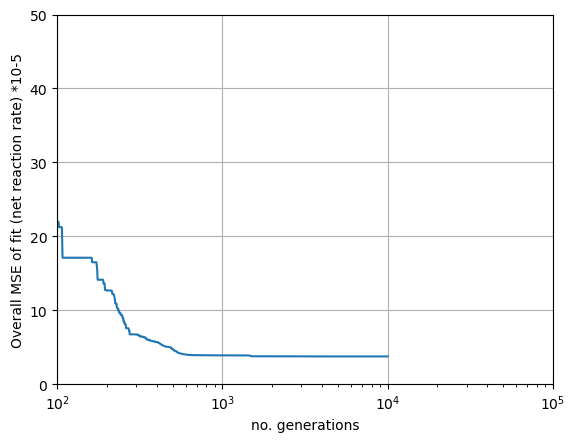

In [32]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [33]:
for i in range(len (res.X)):
    print (res.X[i])

1.0975188355302634
8.595049040568089
8.604654392597137
0.29811427283323777
7.570504777946295
7.589782953073055
7.636671463643756
2.5672891164227827
8.640523643044988
8.565864760679931
8.713682857494218
8.558328498914415
0.6545421061147552
6.639818524829276
6.105807438520099
6.997618218184658
6.675070162688586
1.3321515454972057
7.351900295673514
1.3075822710480307
8.29882760733992
8.31890799758805
8.323560495368692
7.327355515688634
0.9281125942496969
6.942022384377574
3.992897771425801
7.005562742095728
8.998826849980532
8.995436569381056
0.2747586105752937
7.275689542290116
-1.3010299999999997
0.3840430935246365


In [34]:
res.X

array([ 1.09751884,  8.59504904,  8.60465439,  0.29811427,  7.57050478,
        7.58978295,  7.63667146,  2.56728912,  8.64052364,  8.56586476,
        8.71368286,  8.5583285 ,  0.65454211,  6.63981852,  6.10580744,
        6.99761822,  6.67507016,  1.33215155,  7.3519003 ,  1.30758227,
        8.29882761,  8.318908  ,  8.3235605 ,  7.32735552,  0.92811259,
        6.94202238,  3.99289777,  7.00556274,  8.99882685,  8.99543657,
        0.27475861,  7.27568954, -1.30103   ,  0.38404309])

In [35]:
# Use stored solution
kr = [1e+01, 10**8.5,10**8.5, # AtoB
      1e+02, 10**9, 10**9, 10**9, # HMGS
      1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # HMGR
      1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # MK        
      1e+02, 1e+08, # PMK
      1e+01, 1e+08, 1e+08, 1e+08, 1e+07, # PMD
      1e+01, 1e+07, # IDI 
      1e+03, 1e+06, 1e+08, 1e+08, # GPPS
      1e+01, 1e+08, # LS
      10**0.1] # Vin set to 0.05, ks3
    
import numpy as np
logkr=np.log10(kr)
logkr

array([1. , 8.5, 8.5, 2. , 9. , 9. , 9. , 2. , 8. , 8. , 8. , 8. , 2. ,
       8. , 8. , 8. , 8. , 2. , 8. , 1. , 8. , 8. , 8. , 7. , 1. , 7. ,
       3. , 6. , 8. , 8. , 1. , 8. , 0.1])

In [36]:
for i in range(len (logkr)):
    print (logkr[i])

1.0
8.5
8.5
2.0
9.0
9.0
9.0
2.0
8.0
8.0
8.0
8.0
2.0
8.0
8.0
8.0
8.0
2.0
8.0
1.0
8.0
8.0
8.0
7.0
1.0
7.0
3.0
6.0
8.0
8.0
1.0
8.0
0.10000000000000002


In [37]:
y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-2]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

1.0: 1.0975188355302634
8.5: 8.595049040568089
8.5: 8.604654392597137
2.0: 0.29811427283323777
9.0: 7.570504777946295
9.0: 7.589782953073055
9.0: 7.636671463643756
2.0: 2.5672891164227827
8.0: 8.640523643044988
8.0: 8.565864760679931
8.0: 8.713682857494218
8.0: 8.558328498914415
2.0: 0.6545421061147552
8.0: 6.639818524829276
8.0: 6.105807438520099
8.0: 6.997618218184658
8.0: 6.675070162688586
2.0: 1.3321515454972057
8.0: 7.351900295673514
1.0: 1.3075822710480307
8.0: 8.29882760733992
8.0: 8.31890799758805
8.0: 8.323560495368692
7.0: 7.327355515688634
1.0: 0.9281125942496969
7.0: 6.942022384377574
3.0: 3.992897771425801
6.0: 7.005562742095728
8.0: 8.998826849980532
8.0: 8.995436569381056
1.0: 0.2747586105752937
8.0: 7.275689542290116
0.10000000000000002: 0.3840430935246365
coeff fit: 0.9120922893974048
r: 0.9550352294012011


In [1]:
# Use stored solution
kr = [1e+01, 10**8.5,10**8.5, # AtoB
      1e+02, 10**9, 10**9, 10**9, # HMGS
      1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # HMGR
      1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # MK        
      1e+02, 1e+08, # PMK
      1e+01, 1e+08, 1e+08, 1e+08, 1e+07, # PMD
      1e+01, 1e+07, # IDI 
      1e+03, 1e+06, 1e+08, 1e+08, # GPPS
      1e+01, 1e+08, # LS
      10**0.1] # Vin set to 0.05, ks3

import numpy as np
logkr=np.log10(kr)
logkr=np.ndarray.tolist(logkr)
y_mean = np.mean(logkr)


# average of log kr of 3 seeds
krseed1 = [ 1.09751884,  8.59504904,  8.60465439,  0.29811427,  7.57050478,
        7.58978295,  7.63667146,  2.56728912,  8.64052364,  8.56586476,
        8.71368286,  8.5583285 ,  0.65454211,  6.63981852,  6.10580744,
        6.99761822,  6.67507016,  1.33215155,  7.3519003 ,  1.30758227,
        8.29882761,  8.318908  ,  8.3235605 ,  7.32735552,  0.92811259,
        6.94202238,  3.99289777,  7.00556274,  8.99882685,  8.99543657,
        0.27475861,  7.27568954, -1.30103   ,  0.38404309]
#np.ndarray.tolist(res.X)
krseed10 = [ 1.10198671,  8.60145557,  8.58894671,  0.61949462,  8.41667255,
        8.41319384,  8.42343734,  1.35299039,  7.4064611 ,  7.37657073,
        7.47020704,  7.34584018,  0.62229382,  6.59432942,  6.28241147,
        6.91620989,  6.64141216,  0.41332124,  6.4292566 ,  0.36676811,
        7.36775892,  7.37173176,  7.39042175,  6.38380275,  0.75921247,
        6.76950802,  2.85816826,  5.87334969,  7.86267651,  7.86768912,
        0.34663461,  7.35719798, -1.30103   ,  0.89295234]
krseed101 = [ 1.40894029,  8.91209093,  8.926637  ,  0.53183487,  8.47452879,
        8.45917979,  8.43725284,  2.67416761,  8.70570463,  8.70217128,
        8.80035631,  8.67124762,  2.66330846,  8.69332083,  8.43447289,
        8.90008771,  8.6749978 ,  1.69043078,  7.70793934,  1.29487919,
        8.30388331,  8.28662756,  8.30945465,  7.31292726,  1.21547651,
        7.22471077,  0.77226117,  3.79111774,  5.78233753,  5.77140194,
        0.42560454,  7.43335665, -1.30103   ,  1.02453627]

krs = np.array([ krseed1, krseed10, krseed101])

meankr=np.average(krs, axis=0)

meankr=np.ndarray.tolist(meankr)
del meankr[-2]

# R2 of fitting actual logkr =  modeled logkr

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,meankr):
    #print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

for i in range(len (meankr)):
    print (meankr[i])

coeff fit: 0.9642483715632406
r: 0.9819614918942803
1.20281528
8.702865179999998
8.706746033333333
0.48314791999999995
8.15390204
8.154052193333333
8.165787213333333
2.19814904
8.250896456666666
8.214868923333334
8.32808207
8.191805433333334
1.3133814633333334
7.3091562566666655
6.940897266666667
7.604638606666666
7.330493373333333
1.1453011899999999
7.16303208
0.98974319
7.990156613333333
7.9924224399999995
8.0078123
7.00802851
0.9676005233333335
6.978747056666667
2.541109066666667
5.556676723333333
7.547946963333334
7.544842543333334
0.3489992533333333
7.355414723333333
0.7671772333333333


In [2]:
def power(list):
    return [ 10**x for x in list ]
power(meankr)

[15.952005106778014,
 504504657.589211,
 509033111.69165105,
 3.0419209226133406,
 142528606.80549517,
 142577893.28356564,
 146482995.7886475,
 157.81527629561248,
 178195386.8104642,
 164009469.30190763,
 212854124.51413622,
 155526870.53151372,
 20.5769718445255,
 20377751.25641081,
 8727648.894763047,
 40238205.72077568,
 21403922.67424354,
 13.973371001825061,
 14555665.948464986,
 9.76659525141504,
 97758969.14202952,
 98270335.78095682,
 101815125.28420931,
 10186582.574132632,
 9.281122894129314,
 9522413.94671659,
 347.6234509949857,
 360310.3382355493,
 35314004.11888847,
 35062472.93244163,
 2.2335683827345547,
 22668079.303334482,
 5.850287826577263]

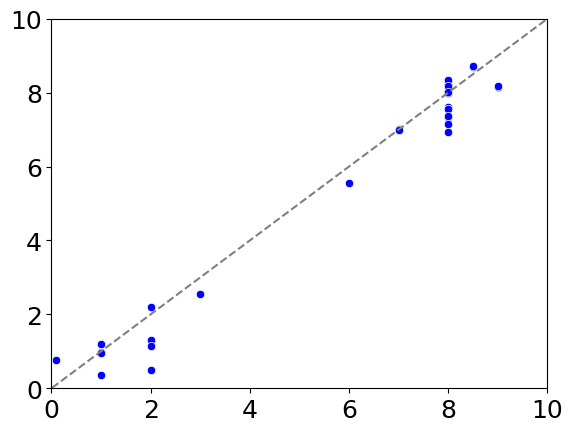

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot using Seaborn
sns.scatterplot(x=logkr, y= meankr, color='blue') #, label='Data Points')

# Add labels and title
#plt.xlabel('True parameter values (log10)')
#plt.ylabel('Fitted parameter values (log10)')

plt.xlim([0, 10])
plt.ylim([0, 10])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18) 

# Add a diagonal line
plt.plot([-15, 15], [-15, 15], color='grey', linestyle='--', label='Diagonal Line')


# Display the plot
plt.show()